# BiomedCLIP Advanced Pipeline for Medical Image Captioning

This notebook implements an optimized end-to-end pipeline for medical image captioning using Vision-Language Models (VLM) with advanced retrieval techniques.

## Key Features

- **Advanced Retrieval**: Temperature scaling and class-aware retrieval
- **Fine-tuning**: Cross-modal embedding alignment optimization
- **Visualization**: Comprehensive embedding space analysis
- **Class-specific Enhancements**: Domain-tailored prompt engineering

## Technical Requirements

- PyTorch with CUDA support (optional, will use CPU if unavailable)
- FAISS for efficient similarity search
- BiomedCLIP pretrained model (automatically downloaded)
- BreakHis or similar medical image dataset

## Getting Started

Run the cells in sequence. The pipeline includes dependency checks and will install missing components.


In [1]:

# Cell 1: Dependencies installation with robust error handling
import sys
import subprocess
import platform
import importlib
from importlib.util import find_spec
from pathlib import Path
import os

print("=" * 60)
print("MEDICAL VISION-LANGUAGE MODEL PIPELINE - DEPENDENCIES SETUP")
print("=" * 60)

# Define required packages with version constraints
required_packages = {
    'numpy': '1.26.4' if platform.system() == 'Windows' else None,
    'torch': None,
    'open-clip-torch': '2.23.0',
    'transformers': None,
    'faiss-cpu': None,  # Always use CPU version for stability
    'matplotlib': None,
    'scikit-learn': None,
    'tqdm': None,
    'ipywidgets': None,
    'pillow': None,
    'pandas': None,
    'sentence-transformers': None,
}

# Check if CUDA is available through PyTorch
try:
    import torch
    cuda_available = torch.cuda.is_available()
    if cuda_available:
        cuda_version = torch.version.cuda
        print(f"✓ CUDA is available (version {cuda_version})")
        print("  Will use GPU acceleration for model inference")
    else:
        print("⚠ CUDA not available - will use CPU processing")
except ImportError:
    cuda_available = False
    print("⚠ PyTorch not found - will install it")

# Helper function to check if a package is installed
def is_package_installed(package_name):
    base_name = package_name.split('-')[0]  # Handle packages like 'faiss-cpu'
    try:
        spec = find_spec(base_name)
        return spec is not None
    except (ImportError, AttributeError, ModuleNotFoundError):
        return False

# Helper function to check package version
def check_package_version(package_name, required_version=None):
    """Check if package meets version requirements.
    Returns: (is_installed, meets_version, current_version)"""
    base_name = package_name.split('-')[0]
    
    try:
        module = importlib.import_module(base_name)
        if not required_version:
            return True, True, getattr(module, '__version__', 'unknown')
            
        if hasattr(module, '__version__'):
            current_version = module.__version__
            # Simple version check (not semantic versioning)
            meets_version = current_version == required_version
            return True, meets_version, current_version
        else:
            return True, False, 'unknown'
    except (ImportError, ModuleNotFoundError):
        return False, False, None

# Identify missing or version-mismatched packages
print("\nChecking required packages...")
missing_packages = []

for package, version in required_packages.items():
    if version:
        installed, version_ok, current_ver = check_package_version(package, version)
        if not installed or not version_ok:
            req_str = f"{package}=={version}"
            missing_packages.append(req_str)
            if installed:
                print(f"⚠ {package} version mismatch: found {current_ver}, need {version}")
    elif not is_package_installed(package):
        missing_packages.append(package)

# Check for faiss-gpu and remove if found (we want faiss-cpu for stability)
try:
    import faiss
    if hasattr(faiss, 'StandardGpuResources'):
        print("Found faiss-gpu installed - will replace with faiss-cpu for stability")
        missing_packages.append('faiss-cpu')
        subprocess.call([sys.executable, "-m", "pip", "uninstall", "-y", "faiss-gpu"])
except ImportError:
    # faiss not installed at all
    pass

# Install missing packages
if missing_packages:
    print(f"\nInstalling missing packages: {', '.join(missing_packages)}")
    
    # Install NumPy first if needed (required by many packages)
    if any(p.startswith('numpy') for p in missing_packages):
        numpy_pkg = next((p for p in missing_packages if p.startswith('numpy')), 'numpy')
        print(f"Installing {numpy_pkg} first (foundation dependency)...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", numpy_pkg])
            print(f"✓ Successfully installed {numpy_pkg}")
            missing_packages = [p for p in missing_packages if not p.startswith('numpy')]
        except subprocess.CalledProcessError:
            print(f"⚠ Failed to install {numpy_pkg}")
    
    # Install remaining packages one by one
    for package in missing_packages:
        print(f"Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", package])
            print(f"✓ Successfully installed {package}")
        except subprocess.CalledProcessError:
            print(f"⚠ Failed to install {package}")
else:
    print("✓ All required packages are already installed")

# Verify critical packages
print("\nVerifying critical packages:")

# Test PyTorch + CUDA
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    if torch.cuda.is_available():
        print(f"✓ CUDA available: {torch.version.cuda}")
        print(f"  Device count: {torch.cuda.device_count()}")
        print(f"  Current device: {torch.cuda.current_device()}")
        print(f"  Device name: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠ CUDA not available, using CPU only")
except ImportError as e:
    print(f"⚠ PyTorch import failed: {e}")

# Test NumPy
try:
    import numpy
    print(f"NumPy version: {numpy.__version__}")
except ImportError as e:
    print(f"⚠ NumPy import failed: {e}")

# Test FAISS
try:
    import faiss
    print(f"FAISS version: {faiss.__version__ if hasattr(faiss, '__version__') else 'unknown'}")
    print(f"FAISS type: {'CPU-only' if not hasattr(faiss, 'StandardGpuResources') else 'Has GPU components'}")
    
    # Create a test index
    d = 64  # dimension
    index = faiss.IndexFlatL2(d)
    print(f"✓ FAISS test successful - created index with dimension {d}")
except ImportError as e:
    print(f"⚠ FAISS import failed: {e}")
except Exception as e:
    print(f"⚠ FAISS test failed: {e}")

print("\n✓ Dependency setup complete")

MEDICAL VISION-LANGUAGE MODEL PIPELINE - DEPENDENCIES SETUP
⚠ CUDA not available - will use CPU processing

Checking required packages...

Installing missing packages: open-clip-torch==2.23.0, scikit-learn, pillow, sentence-transformers
Installing open-clip-torch==2.23.0...
⚠ CUDA not available - will use CPU processing

Checking required packages...

Installing missing packages: open-clip-torch==2.23.0, scikit-learn, pillow, sentence-transformers
Installing open-clip-torch==2.23.0...
✓ Successfully installed open-clip-torch==2.23.0
Installing scikit-learn...
✓ Successfully installed open-clip-torch==2.23.0
Installing scikit-learn...
✓ Successfully installed scikit-learn
Installing pillow...
✓ Successfully installed scikit-learn
Installing pillow...
✓ Successfully installed pillow
Installing sentence-transformers...
✓ Successfully installed pillow
Installing sentence-transformers...
✓ Successfully installed sentence-transformers

Verifying critical packages:
PyTorch version: 2.7.1+cpu


# Configuration and Utilities

This section sets up the pipeline configuration and utility functions for data processing, model inference, and retrieval.

## Key Features

- **Dynamic Configuration**: Easily adjustable parameters for experimentation
- **Utility Functions**: Reusable functions for directory management, tokenization, etc.
- **Advanced Retrieval Methods**: Temperature scaling and class-aware retrieval

## Getting Started

Run this cell to initialize the configuration and utility functions. Modify the `CONFIG` dictionary to change parameters.


In [2]:

# Cell 2: Configuration and utilities
import os
import json
import time
import random
import torch
import numpy as np
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Union, Any, Callable

print("=" * 60)
print("PIPELINE CONFIGURATION AND UTILITIES")
print("=" * 60)

# Set up config with key parameters
CONFIG = {
    # Paths
    "DATASET_DIR": "f:/VLM_pipeline/BreaKHis_v1/histology_slides/breast/",
    "OUT_DIR": "f:/VLM_pipeline/outputs",
    "HF_CACHE_DIR": "f:/VLM_pipeline/hf_cache",
    
    # Model configuration
    "BIOMEDCLIP_HF_ID": "microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    
    # Data processing
    "BATCH_IMAGE": 8 if torch.cuda.is_available() else 1,
    "BATCH_TEXT": 32 if torch.cuda.is_available() else 4,
    
    # Retrieval parameters
    "TOP_K": 5,
    "TEMPERATURE": 0.07,  # Lower = sharper similarity distribution
    "SIMILARITY_THRESHOLD": 0.20,
    
    # Class-aware retrieval parameters
    "BENIGN_BOOST": 1.5,   # Multiplier for relevant benign terms
    "MALIGNANT_BOOST": 1.5,  # Multiplier for relevant malignant terms
    "CLASS_PENALTY": 0.5,  # Multiplier for wrong-class terms
    
    # Fine-tuning parameters
    "FINE_TUNING_ENABLED": False,  # Change to True to enable fine-tuning
    "FINE_TUNING_EPOCHS": 20,
    "FINE_TUNING_LR": 0.0005,
    "EMBEDDING_DIM": 256,  # Projection dimension
    
    # Development/debug options
    "SAMPLE_MODE": True,  # Use reduced dataset for faster development
    "SAMPLE_MAX_IMAGES": 100,  # Max images to process in sample mode
}

# Create output directory
OUT_DIR = Path(CONFIG["OUT_DIR"])
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Set up HuggingFace cache
os.environ['TRANSFORMERS_CACHE'] = CONFIG["HF_CACHE_DIR"]
os.environ['HF_HOME'] = CONFIG["HF_CACHE_DIR"]
Path(CONFIG["HF_CACHE_DIR"]).mkdir(parents=True, exist_ok=True)

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Utility functions
def safe_makedir(path):
    """Create directory if it doesn't exist"""
    Path(path).mkdir(parents=True, exist_ok=True)
    return path

# Text tokenizer utilities
TEXT_TOKENIZER = None  # Will be set after model loading

def prepare_text_tokens(texts, device="cpu"):
    """
    Process text inputs for the vision-language model with error handling.
    Works with both CLIP and OpenCLIP tokenizers.
    
    Args:
        texts: List of text strings to encode
        device: Target device for the tokens
        
    Returns:
        Tokenized text that can be passed to model.encode_text()
    """
    global TEXT_TOKENIZER
    
    if TEXT_TOKENIZER is None:
        # Fallback to open_clip's tokenize function if available
        try:
            from open_clip import tokenize
            tokens = tokenize(texts)
            return tokens.to(device)
        except (ImportError, AttributeError):
            raise RuntimeError("No text tokenizer available - run model loading cell first")
            
    torch_device = torch.device(device)
    
    # Handle different tokenizer types
    if hasattr(TEXT_TOKENIZER, "__call__"):
        try:
            # Try HuggingFace style tokenizer first
            try:
                encoded = TEXT_TOKENIZER(
                    texts,
                    padding="max_length",
                    truncation=True,
                    max_length=min(getattr(TEXT_TOKENIZER, "model_max_length", 77), 77),
                    return_tensors="pt"
                )
                if isinstance(encoded, dict):
                    return {k: v.to(torch_device) for k, v in encoded.items()}
            except (TypeError, AttributeError):
                # Fallback to simple tokenization
                pass
                
            # Standard CLIP/OpenCLIP tokenizer
            tokens = TEXT_TOKENIZER(texts)
            if isinstance(tokens, dict):
                return {k: v.to(torch_device) for k, v in tokens.items()}
            return tokens.to(torch_device)
            
        except Exception as e:
            print(f"⚠ Tokenization error: {e}")
            # Last resort - try open_clip.tokenize directly
            try:
                from open_clip import tokenize
                return tokenize(texts).to(torch_device)
            except ImportError:
                raise RuntimeError(f"Text tokenization failed: {e}")
    
    raise ValueError("TEXT_TOKENIZER is not callable")

# Temperature scaling for better similarity distribution
def apply_temperature_scaling(similarities, temperature=CONFIG["TEMPERATURE"]):
    """Apply temperature scaling to sharpen similarity distribution"""
    return similarities / temperature

# Class-aware retrieval for better relevance
def class_aware_retrieval(img_embedding, text_embeddings, corpus, metadata, top_k=5, temperature=CONFIG["TEMPERATURE"]):
    """Perform retrieval with class-aware reranking"""
    # Extract class from metadata (benign/malignant)
    img_class = metadata.get("tumor_class", "Unknown").lower()
    
    # Normalize image embedding
    img_emb_norm = img_embedding / np.linalg.norm(img_embedding)
    
    # Get raw similarities
    similarities = np.dot(text_embeddings, img_emb_norm)
    
    # Apply temperature scaling to increase contrast
    similarities = apply_temperature_scaling(similarities, temperature)
    
    # Get indices sorted by similarity
    indices = np.argsort(-similarities)
    
    # First get all matches
    all_matches = [(corpus[int(idx)], float(similarities[idx])) for idx in indices[:top_k*3]]
    
    # Now boost class-specific descriptions
    scored_matches = []
    for text, score in all_matches:
        text_lower = text.lower()
        # Check if text mentions the class or related terms
        class_relevance = 1.0  # Default multiplier
        
        if img_class == "benign":
            if any(term in text_lower for term in ["benign", "fibroadenoma", "adenosis", "normal", "hyperplasia"]):
                class_relevance = CONFIG["BENIGN_BOOST"]  # Boost benign-related terms
            if any(term in text_lower for term in ["malignant", "carcinoma", "invasive", "ductal carcinoma"]):
                class_relevance = CONFIG["CLASS_PENALTY"]  # Penalize wrong-class terms
                
        elif img_class == "malignant":
            if any(term in text_lower for term in ["malignant", "carcinoma", "invasive", "ductal carcinoma", "pleomorphism"]):
                class_relevance = CONFIG["MALIGNANT_BOOST"]  # Boost malignant-related terms
            if any(term in text_lower for term in ["benign", "fibroadenoma", "adenosis", "normal", "hyperplasia"]):
                class_relevance = CONFIG["CLASS_PENALTY"]  # Penalize wrong-class terms
        
        # Adjust score by class relevance
        orig_score = score  # Store the original score before adjustment
        adjusted_score = score * class_relevance
        scored_matches.append((text, adjusted_score, orig_score))  # Store original and adjusted scores
    
    # Sort by adjusted score and return top_k
    scored_matches.sort(key=lambda x: x[1], reverse=True)
    
    return [(text, adj_score, orig_score) for text, adj_score, orig_score in scored_matches[:top_k]]

# Extract metadata from BreakHis filename structure
def extract_breakhis_metadata(img_path):
    """Extract detailed metadata from BreakHis filename structure
    
    Format examples: 
    - SOB_B_A-14-22549AB-40-001.png (Surgical Open Biopsy, Benign, Adenosis, etc.)
    - SOB_M_DC-14-4726-40-001.png (Surgical Open Biopsy, Malignant, Ductal Carcinoma)
    """
    try:
        filename = Path(img_path).stem
        parts = filename.split('_')
        if len(parts) < 3:
            return {}
            
        # Parse biopsy type
        biopsy_type = {
            'SOB': 'Surgical Open Biopsy',
            'CNB': 'Core Needle Biopsy'
        }.get(parts[0], 'Unknown')
        
        # Parse tumor class
        tumor_class = {
            'B': 'Benign',
            'M': 'Malignant'
        }.get(parts[1], 'Unknown')
        
        # Parse tumor type and magnification
        detail_parts = parts[2].split('-')
        tumor_code = detail_parts[0]
        
        tumor_types = {
            'A': 'Adenosis',
            'F': 'Fibroadenoma',
            'TA': 'Tubular Adenoma',
            'PT': 'Phyllodes Tumor',
            'DC': 'Ductal Carcinoma',
            'LC': 'Lobular Carcinoma',
            'MC': 'Mucinous Carcinoma',
            'PC': 'Papillary Carcinoma'
        }
        
        tumor_type = tumor_types.get(tumor_code, 'Unknown')
        
        # Extract magnification if available
        magnification = "Unknown"
        for part in detail_parts:
            if part in ['40', '100', '200', '400']:
                magnification = f"{part}X"
                break
        
        return {
            "biopsy_type": biopsy_type,
            "tumor_class": tumor_class,
            "tumor_type": tumor_type,
            "magnification": magnification
        }
    except Exception:
        return {}

print("\n✓ Configuration and utilities loaded")
print(f"  Using device: {CONFIG['DEVICE']}")
print(f"  Output directory: {OUT_DIR}")
print(f"  Dataset path: {CONFIG['DATASET_DIR']}")

PIPELINE CONFIGURATION AND UTILITIES

✓ Configuration and utilities loaded
  Using device: cpu
  Output directory: f:\VLM_pipeline\outputs
  Dataset path: f:/VLM_pipeline/BreaKHis_v1/histology_slides/breast/


# Model Loading and Initialization

This section handles the loading of the BiomedCLIP model with robust error handling and fallback options.

## Key Features

- **Flexible Model Loading**: Supports loading from Hugging Face Hub or local files
- **Automatic Device Placement**: Models are automatically moved to the correct device (CPU or GPU)
- **Tokenizer Configuration**: Configures the text tokenizer based on the loaded model

## Getting Started

Run this cell to load the BiomedCLIP model. This may take some time depending on your internet speed and system performance.


In [3]:

# Cell 3: Load model with robust fallbacks
import torch
import open_clip
from pathlib import Path
import time

print("=" * 60)
print("LOADING BIOMEDCLIP MODEL")
print("=" * 60)

device = CONFIG["DEVICE"]
model_id = CONFIG["BIOMEDCLIP_HF_ID"]

# Try to import huggingface_hub
try:
    from huggingface_hub import HfFolder
    import huggingface_hub
    has_hf_hub = True
except ImportError:
    has_hf_hub = False
    print("⚠ huggingface_hub not installed, will use local fallbacks only")

# Helper to load model and preprocess
def load_biomedclip(hf_id: str, device: str = "cpu"):
    """Load BiomedCLIP with fallbacks if the main model fails"""
    print(f"Attempting to load model: {hf_id}")
    
    # Strip 'hf-hub:' prefix if present
    if hf_id.startswith("hf-hub:"):
        hf_id = hf_id[7:]
    
    # Approach 1: Try direct HF hub download with open_clip (best option)
    if has_hf_hub:
        try:
            print("Attempting OpenCLIP HF Hub direct loading...")
            model, preprocess = open_clip.create_model_from_pretrained(
                f"hf-hub:{hf_id}", 
                cache_dir=CONFIG["HF_CACHE_DIR"],
                device=device
            )
            model = model.to(device).eval()
            print("✓ Successfully loaded model via HF Hub")
            return model, preprocess
        except Exception as e1:
            print(f"HF Hub loading failed: {e1}")
    else:
        print("Skipping HF Hub loading (huggingface_hub not available)")
        
    # Approach 2: Try standard open_clip model
    try:
        print("Trying standard OpenCLIP models...")
        model_name = "ViT-B-16"  # Same architecture as BiomedCLIP
        available_pretrained = open_clip.list_pretrained()
        pretrained_options = [p for name, p in available_pretrained if name == model_name]
        
        if pretrained_options:
            pretrained = pretrained_options[0]
            print(f"Using {model_name} with {pretrained} weights")
            model, _, preprocess = open_clip.create_model_and_transforms(
                model_name, 
                pretrained=pretrained
            )
            model = model.to(device).eval()
            print(f"✓ Loaded alternative model: {model_name} with {pretrained} weights")
            print("⚠ Note: This is not BiomedCLIP, but a similar architecture")
            return model, preprocess
    except Exception as e2:
        print(f"Standard OpenCLIP loading failed: {e2}")

    # Approach 3: Last resort - try any available OpenCLIP model
    try:
        print("Trying ANY available OpenCLIP model as last resort...")
        available_models = open_clip.list_pretrained()
        if available_models:
            model_name, pretrained = available_models[0]
            print(f"Falling back to {model_name} with {pretrained}")
            model, _, preprocess = open_clip.create_model_and_transforms(
                model_name, 
                pretrained=pretrained
            )
            model = model.to(device).eval()
            print(f"✓ Loaded fallback model: {model_name}")
            return model, preprocess
    except Exception as e3:
        print(f"Fallback loading failed: {e3}")

    # If all approaches fail
    raise RuntimeError("All model loading approaches failed.")

# Load model with timing
start_time = time.time()
print("Loading model (this may take a few minutes)...")

try:
    model, preprocess = load_biomedclip(model_id, device=device)
except Exception as e:
    print(f"Initial loading failed: {e}")
    print("Trying simplified model ID...")
    try:
        simplified_id = "microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"
        model, preprocess = load_biomedclip(simplified_id, device=device)
    except Exception as e2:
        print(f"All loading attempts failed for BiomedCLIP.")
        print("\nAttempting to load original CLIP as last resort...")
        try:
            import clip
            model, preprocess = clip.load("ViT-B/16", device=device)
            print("✓ Loaded original OpenAI CLIP model as fallback")
        except Exception as e3:
            raise RuntimeError(f"Cannot load any model. Error: {e3}")

# Ensure model has required methods
if not hasattr(model, "encode_image") or not hasattr(model, "encode_text"):
    raise RuntimeError("Model doesn't have expected encode_image/encode_text methods")

elapsed = time.time() - start_time
print(f"✓ Model loaded in {elapsed:.1f} seconds")
print(f"  Type: {type(model).__name__}")
print(f"  Device: {next(model.parameters()).device}")

# Initialize tokenizer based on model type
print("\nConfiguring text tokenizer...")

def _setup_tokenizer(model):
    """Set up the appropriate tokenizer for the loaded model"""
    global TEXT_TOKENIZER
    
    # Try to get tokenizer from model's configuration
    model_key = getattr(model, "hf_hub_id", None)
    cfg = getattr(model, "pretrained_cfg", {}) if isinstance(getattr(model, "pretrained_cfg", {}), dict) else {}
    
    candidates = [
        CONFIG["BIOMEDCLIP_HF_ID"],
        model_key,
        cfg.get("hf_hub_id"),
        cfg.get("model_name"),
        cfg.get("id"),
        "ViT-B-16", 
        "ViT-B/16"
    ]
    
    # Try each candidate
    for candidate in candidates:
        if not candidate:
            continue
            
        for key in (candidate, f"hf-hub:{candidate}"):
            try:
                TEXT_TOKENIZER = open_clip.get_tokenizer(key)
                if TEXT_TOKENIZER is not None:
                    return TEXT_TOKENIZER
            except Exception:
                continue
    
    # Fallbacks
    if hasattr(model, "tokenizer"):
        TEXT_TOKENIZER = model.tokenizer
    elif "clip" in globals() and hasattr(clip, "tokenize"):
        TEXT_TOKENIZER = clip.tokenize
    else:
        # Last resort - use OpenCLIP's tokenize function
        from open_clip import tokenize
        TEXT_TOKENIZER = tokenize
    
    return TEXT_TOKENIZER

# Set up tokenizer and test it
TEXT_TOKENIZER = _setup_tokenizer(model)
print(f"✓ Text tokenizer configured (type: {type(TEXT_TOKENIZER).__name__})")

# Test tokenizer and model with a simple example
test_img = torch.randn(1, 3, 224, 224).to(device)
test_text = ["A test sentence to verify encoding works."]

with torch.no_grad():
    # Test image encoding
    img_features = model.encode_image(test_img)
    print(f"✓ Image encoding test successful (output shape: {img_features.shape})")
    
    # Test text encoding with our tokenizer
    try:
        token_inputs = prepare_text_tokens(test_text, device=device)
        text_features = model.encode_text(token_inputs)
        print(f"✓ Text encoding test successful (output shape: {text_features.shape})")
    except Exception as e:
        print(f"⚠ Text encoding test failed: {e}")
        print("  Check tokenizer configuration")

print("\n✓ Model loaded and tested successfully")

c:\Users\BTBM\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
c:\Users\BTBM\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\BTBM\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


LOADING BIOMEDCLIP MODEL
Loading model (this may take a few minutes)...
Attempting to load model: microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224
Attempting OpenCLIP HF Hub direct loading...
✓ Successfully loaded model via HF Hub
✓ Model loaded in 4.3 seconds
  Type: CustomTextCLIP
  Device: cpu

Configuring text tokenizer...
✓ Successfully loaded model via HF Hub
✓ Model loaded in 4.3 seconds
  Type: CustomTextCLIP
  Device: cpu

Configuring text tokenizer...
✓ Text tokenizer configured (type: HFTokenizer)
✓ Image encoding test successful (output shape: torch.Size([1, 512]))
✓ Text tokenizer configured (type: HFTokenizer)
✓ Image encoding test successful (output shape: torch.Size([1, 512]))
✓ Text encoding test successful (output shape: torch.Size([1, 512]))

✓ Model loaded and tested successfully
✓ Text encoding test successful (output shape: torch.Size([1, 512]))

✓ Model loaded and tested successfully


# Dataset Preparation and Image Embeddings

This section prepares the dataset for training and evaluation, including image loading, preprocessing, and embedding computation.

## Key Features

- **Image Collection**: Recursively collects images from the dataset directory
- **Metadata Extraction**: Extracts and saves metadata from image filenames
- **Image Embedding**: Computes and caches image embeddings using the BiomedCLIP model

## Getting Started

Run this cell to prepare the dataset and compute image embeddings. Ensure that the dataset path is correctly set in the configuration.


In [4]:

# Cell 4: Dataset preparation and image embeddings
import numpy as np
import json
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm

print("=" * 60)
print("DATASET PREPARATION AND IMAGE EMBEDDING")
print("=" * 60)

# Define file paths for caching
IMAGE_EMB_FILE = OUT_DIR / "image_embeddings.npy"
IMAGE_PATHS_FILE = OUT_DIR / "image_paths.json"
METADATA_FILE = OUT_DIR / "image_metadata.json"

# Collect images from dataset
def collect_images(root_dir: Path):
    """Recursively collect all image files from a directory"""
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    files = []
    
    print(f"Scanning for images in: {root_dir}")
    for p in root_dir.rglob("*"):
        if p.suffix.lower() in exts and p.is_file():
            files.append(str(p))
    
    files = sorted(files)
    return files

# Check dataset path
DATASET_DIR = Path(CONFIG["DATASET_DIR"]).expanduser()
if not DATASET_DIR.exists():
    raise FileNotFoundError(f"Dataset not found at {DATASET_DIR}")

# Get image paths
print("Collecting images from dataset...")
image_paths = collect_images(DATASET_DIR)

if len(image_paths) == 0:
    raise RuntimeError(f"No image files found in {DATASET_DIR}")

# Apply sample limit if in sample mode
if CONFIG["SAMPLE_MODE"] and len(image_paths) > CONFIG["SAMPLE_MAX_IMAGES"]:
    print(f"Sample mode: limiting to {CONFIG['SAMPLE_MAX_IMAGES']} images")
    
    # Get a balanced sample if possible
    benign_paths = [p for p in image_paths if "benign" in p.lower()]
    malignant_paths = [p for p in image_paths if "malignant" in p.lower()]
    other_paths = [p for p in image_paths if "benign" not in p.lower() and "malignant" not in p.lower()]
    
    if benign_paths and malignant_paths:
        # Balance classes
        max_per_class = CONFIG["SAMPLE_MAX_IMAGES"] // 2
        sampled_benign = benign_paths[:min(len(benign_paths), max_per_class)]
        sampled_malignant = malignant_paths[:min(len(malignant_paths), max_per_class)]
        
        # If we still have space, add other images
        remaining = CONFIG["SAMPLE_MAX_IMAGES"] - len(sampled_benign) - len(sampled_malignant)
        sampled_other = other_paths[:min(len(other_paths), remaining)] if remaining > 0 else []
        
        image_paths = sampled_benign + sampled_malignant + sampled_other
        print(f"  Balanced sample: {len(sampled_benign)} benign, {len(sampled_malignant)} malignant, {len(sampled_other)} other")
    else:
        # Simple limiting if we can't detect classes
        image_paths = image_paths[:CONFIG["SAMPLE_MAX_IMAGES"]]

print(f"✓ Found {len(image_paths)} images")

# Extract metadata for all images
print("Extracting image metadata...")
all_metadata = {}
for path in tqdm(image_paths, desc="metadata"):
    metadata = extract_breakhis_metadata(path)
    all_metadata[path] = metadata

# Save metadata
with open(METADATA_FILE, "w") as f:
    json.dump(all_metadata, f)
print(f"✓ Saved metadata to {METADATA_FILE}")

# Check for cached embeddings
compute_images = True
if IMAGE_EMB_FILE.exists() and IMAGE_PATHS_FILE.exists():
    print("Found cached image embeddings, checking compatibility...")
    try:
        cached_embeddings = np.load(str(IMAGE_EMB_FILE))
        with open(IMAGE_PATHS_FILE, "r") as f:
            cached_paths = json.load(f)
        
        # Check if cached paths match current paths
        if len(cached_paths) == len(image_paths) and set(cached_paths) == set(image_paths):
            print("✓ Using cached image embeddings")
            compute_images = False
            image_embeddings = cached_embeddings
        else:
            print("⚠ Cached paths don't match current dataset, recomputing embeddings")
    except Exception as e:
        print(f"⚠ Error loading cached embeddings: {e}")
        print("  Will recompute embeddings")

# Compute image embeddings
if compute_images:
    print("Computing image embeddings...")
    model.eval()
    
    batch_size = CONFIG["BATCH_IMAGE"]
    emb_list = []
    valid_paths = []
    failed_images = []
    
    # Process images in batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="encoding images"):
        batch_paths = image_paths[i:i+batch_size]
        batch_imgs = []
        batch_valid_paths = []
        
        # Process each image in the batch
        for p in batch_paths:
            try:
                # Open and preprocess image
                img = Image.open(p).convert("RGB")
                img_tensor = preprocess(img)
                batch_imgs.append(img_tensor)
                batch_valid_paths.append(p)
            except Exception as e:
                failed_images.append((p, str(e)))
                print(f"⚠ Failed to process image {Path(p).name}: {e}")
        
        # Skip empty batches
        if not batch_imgs:
            continue
        
        # Compute embeddings for batch
        try:
            with torch.no_grad():
                tensor = torch.stack(batch_imgs).to(device)
                features = model.encode_image(tensor)
                features = features / features.norm(dim=-1, keepdim=True)
            emb_list.append(features.cpu().numpy())
            valid_paths.extend(batch_valid_paths)
        except Exception as e:
            print(f"⚠ Batch processing failed: {e}")
            # Try one-by-one processing as fallback
            for j, img_tensor in enumerate(batch_imgs):
                try:
                    with torch.no_grad():
                        tensor = img_tensor.unsqueeze(0).to(device)
                        features = model.encode_image(tensor)
                        features = features / features.norm(dim=-1, keepdim=True)
                    emb_list.append(features.cpu().numpy())
                    valid_paths.append(batch_valid_paths[j])
                except Exception as e2:
                    failed_images.append((batch_valid_paths[j], str(e2)))
                    print(f"⚠ Failed to process single image: {e2}")
    
    # Make sure we have embeddings
    if not emb_list:
        raise RuntimeError("No image embeddings could be computed!")
        
    # Concatenate all embeddings
    image_embeddings = np.concatenate(emb_list, axis=0).astype("float32")
    
    # Update image paths to only include successfully processed ones
    image_paths = valid_paths
    
    # Save embeddings and paths
    np.save(IMAGE_EMB_FILE, image_embeddings)
    with open(IMAGE_PATHS_FILE, "w") as f:
        json.dump(image_paths, f)
    
    print(f"✓ Saved {len(image_paths)} image embeddings")
    
    # Save failed image list if any
    if failed_images:
        print(f"⚠ Failed to process {len(failed_images)} images")
        with open(OUT_DIR / "failed_images.json", "w") as f:
            json.dump(failed_images, f, indent=2)

# Summary
print(f"\n✓ Image embeddings ready: {image_embeddings.shape}")

# Show class distribution
benign_count = sum(1 for path in image_paths if "benign" in path.lower())
malignant_count = sum(1 for path in image_paths if "malignant" in path.lower())
print(f"  Class distribution: {benign_count} benign, {malignant_count} malignant, {len(image_paths) - benign_count - malignant_count} other")

DATASET PREPARATION AND IMAGE EMBEDDING
Scanning for images in: f:\VLM_pipeline\BreaKHis_v1\histology_slides\breast
Sample mode: limiting to 100 images
  Balanced sample: 50 benign, 50 malignant, 0 other
✓ Found 100 images
Extracting image metadata...
Sample mode: limiting to 100 images
  Balanced sample: 50 benign, 50 malignant, 0 other
✓ Found 100 images
Extracting image metadata...


metadata:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Saved metadata to f:\VLM_pipeline\outputs\image_metadata.json
Found cached image embeddings, checking compatibility...
✓ Using cached image embeddings

✓ Image embeddings ready: (100, 512)
  Class distribution: 50 benign, 50 malignant, 0 other


# Text Corpus Preparation and Embedding

This section prepares the text corpus for training and evaluation, including building a domain-specific medical corpus and computing its embeddings.

## Key Features

- **Medical Corpus Construction**: Creates a corpus of medical terms and descriptions
- **Text Embedding**: Computes and caches text embeddings using the BiomedCLIP model

## Getting Started

Run this cell to prepare the text corpus and compute embeddings. Ensure that the output directory is correctly set in the configuration.


In [5]:

# Cell 5: Text corpus preparation and embedding
import numpy as np
import json
from tqdm.notebook import tqdm

print("=" * 60)
print("TEXT CORPUS PREPARATION AND EMBEDDING")
print("=" * 60)

# Define file paths for caching
TEXT_EMB_FILE = OUT_DIR / "text_embeddings.npy"
TEXT_CORPUS_FILE = OUT_DIR / "text_corpus.json"

# Function to build enhanced medical corpus
def build_medical_corpus():
    """Create a domain-specific corpus for medical image captioning"""
    # General histology terms
    general_histology = [
        "H&E-stained breast tissue with cellular features",
        "histopathology slide showing tissue architecture",
        "breast tissue section with ductal structures",
        "microscopic view of breast tissue sample",
        "histological section of breast biopsy",
        "breast tissue showing cellular morphology",
        "histopathological features of breast specimen",
        "breast tissue with stromal components",
        "H&E stain showing epithelial structures"
    ]
    
    # Benign-specific descriptions
    benign_descriptions = [
        "benign breast histology with normal ducts",
        "fibroadenoma showing well-circumscribed borders",
        "benign phyllodes tumor with leaf-like projections",
        "tubular adenoma with well-formed glandular structures",
        "adenosis with increased number of small acinar structures",
        "fibrocystic changes with cystic dilation of ducts",
        "benign breast lobules with minimal atypia",
        "myoepithelial cell prominence in benign breast lesion",
        "fibroadenoma with myxoid stroma and epithelial elements",
        "fibrosis with scattered ductal elements",
        "benign sclerosing lesion with preserved architecture",
        "lobular hyperplasia without cytological atypia",
        "microglandular adenosis with uniform small glands",
        "benign papilloma with fibrovascular core and epithelial lining",
        "apocrine metaplasia with abundant eosinophilic cytoplasm",
        "stromal fibrosis with focal microcalcifications",
        "benign breast lesion with well-defined borders",
        "uniform nuclei with minimal variation in size and shape",
        "benign cells with round, regular nuclei and abundant cytoplasm",
        "lobules with maintained architecture and no atypia",
        "benign epithelial proliferation without nuclear atypia",
        "well-circumscribed fibroadenoma with pushing borders",
        "benign lesion with stromal collagenization",
        "regular cellular arrangement with normal nuclear-cytoplasmic ratio",
        "tubular adenoma with intact myoepithelial cell layer",
        "benign breast tissue with regular ductal structures"
    ]
    
    # Malignant-specific descriptions
    malignant_descriptions = [
        "ductal carcinoma in situ with comedo necrosis",
        "invasive ductal carcinoma with desmoplastic stroma",
        "lymphocytic infiltration at tumor margins",
        "vascular invasion by malignant cells",
        "glandular structures with cellular atypia",
        "tissue architecture disruption and loss of polarity",
        "chromatin condensation and nuclear enlargement",
        "abnormal mitotic figures present",
        "lobular carcinoma with single-file cellular arrangement",
        "mucinous carcinoma with abundant extracellular mucin",
        "papillary carcinoma with fibrovascular cores",
        "high-grade invasive carcinoma with marked nuclear pleomorphism",
        "cribriform pattern with sieve-like spaces",
        "infiltrating tumor cells with desmoplastic response",
        "poorly differentiated carcinoma with solid growth pattern",
        "carcinoma with signet ring cell features",
        "medullary carcinoma with syncytial growth and lymphocytic infiltration",
        "metaplastic carcinoma with squamous differentiation",
        "inflammatory carcinoma with dermal lymphatic invasion",
        "malignant breast carcinoma with infiltrative growth pattern",
        "marked nuclear pleomorphism indicative of malignancy",
        "invasive ductal carcinoma with desmoplastic stromal response",
        "malignant cells with prominent nucleoli and irregular chromatin",
        "high nuclear grade carcinoma with mitotic figures",
        "tumor cell infiltration into adjacent breast parenchyma",
        "malignant cells with high nuclear-cytoplasmic ratio",
        "invasive lobular carcinoma with single-file infiltration pattern",
        "architectural distortion with malignant cell infiltration",
        "poorly differentiated malignant cells with nuclear pleomorphism"
    ]
    
    # Cellular features
    cellular_features = [
        "cells exhibiting nuclear pleomorphism and hyperchromasia",
        "prominent nucleoli visible in tumor cells",
        "increased nuclear-to-cytoplasmic ratio in neoplastic cells",
        "abundant eosinophilic cytoplasm in apocrine cells",
        "clear cell changes with vacuolated cytoplasm",
        "spindle cell morphology with elongated nuclei",
        "bizarre multinucleated giant cells present",
        "epithelial cells with loss of cohesion",
        "foamy histiocytes within stroma",
        "plasma cells with eccentric nuclei and perinuclear halo",
        "lymphocytes with round nuclei and scant cytoplasm",
        "necrosis and apoptotic bodies visible in tissue section",
        "stromal fibrosis and inflammation",
        "high mitotic index and cellular pleomorphism"
    ]
    
    # Magnification levels
    magnification_descriptions = [
        "40X magnification showing cellular details",
        "100X magnification of breast tissue",
        "200X magnification revealing nuclear features",
        "400X high-power view of breast carcinoma cells",
        "low power view of breast tissue architecture",
        "high power view showing individual cell morphology",
        "40X magnification revealing overall tissue organization",
        "100X magnification demonstrating cellular arrangements",
        "200X magnification showing nuclear pleomorphism",
        "400X magnification revealing mitotic activity and chromatin patterns",
        "low power field demonstrating tumor borders",
        "high power field focusing on nuclear-cytoplasmic ratio"
    ]
    
    # Technical descriptions
    technical_descriptions = [
        "well-preserved tissue with clear histological features",
        "tissue section shows normal cellular morphology",
        "well-stained breast tissue section",
        "tissue with staining artifacts but interpretable features",
        "well-processed H&E stained breast biopsy",
        "tissue section with minimal fixation artifacts",
        "hematoxylin-eosin stained slide with good contrast",
        "microscopic section with optimal thickness for visualization",
        "well-preserved architecture allowing clear assessment"
    ]
    
    # Combine all categories
    corpus = (
        general_histology + benign_descriptions + malignant_descriptions +
        cellular_features + magnification_descriptions + technical_descriptions
    )
    
    # Remove duplicates while preserving order
    unique_corpus = []
    seen = set()
    for text in corpus:
        if text not in seen:
            seen.add(text)
            unique_corpus.append(text)
    
    return unique_corpus

# Create corpus
print("Preparing text corpus...")
corpus = build_medical_corpus()
print(f"✓ Created corpus with {len(corpus)} unique text prompts")

# Check for cached text embeddings
compute_texts = True
if TEXT_EMB_FILE.exists() and TEXT_CORPUS_FILE.exists():
    print("Found cached text embeddings, checking compatibility...")
    try:
        cached_embeddings = np.load(str(TEXT_EMB_FILE))
        with open(TEXT_CORPUS_FILE, "r") as f:
            cached_corpus = json.load(f)
        
        # Check if cached corpus matches current corpus
        if cached_corpus == corpus:
            print("✓ Using cached text embeddings")
            compute_texts = False
            text_embeddings = cached_embeddings
        else:
            print("⚠ Cached corpus doesn't match current corpus, recomputing embeddings")
    except Exception as e:
        print(f"⚠ Error loading cached text embeddings: {e}")
        print("  Will recompute text embeddings")

# Compute text embeddings
if compute_texts:
    print("Computing text embeddings...")
    model.eval()
    
    batch_size = CONFIG["BATCH_TEXT"]
    all_embeddings = []
    failed_texts = []
    
    # Process texts in batches
    for i in tqdm(range(0, len(corpus), batch_size), desc="encoding texts"):
        batch_texts = corpus[i:i+batch_size]
        
        try:
            with torch.no_grad():
                # Tokenize and encode
                token_inputs = prepare_text_tokens(batch_texts, device=device)
                features = model.encode_text(token_inputs)
                # Normalize
                features = features / features.norm(dim=-1, keepdim=True)
                all_embeddings.append(features.cpu().numpy())
        except Exception as e:
            print(f"⚠ Batch processing failed: {e}")
            # Try one-by-one processing
            for text in batch_texts:
                try:
                    with torch.no_grad():
                        token_inputs = prepare_text_tokens([text], device=device)
                        features = model.encode_text(token_inputs)
                        features = features / features.norm(dim=-1, keepdim=True)
                        all_embeddings.append(features.cpu().numpy())
                except Exception as e2:
                    failed_texts.append((text, str(e2)))
                    print(f"⚠ Failed to encode: '{text[:30]}...' - {e2}")
                    # Use zero embedding as fallback
                    dim = image_embeddings.shape[1]  # Match image dimension
                    zero_emb = np.zeros((1, dim), dtype=np.float32)
                    all_embeddings.append(zero_emb)
    
    # Make sure we have embeddings
    if not all_embeddings:
        raise RuntimeError("No text embeddings could be computed!")
        
    # Concatenate all embeddings
    text_embeddings = np.concatenate(all_embeddings, axis=0).astype("float32")
    
    # Clean up any NaN/Inf values
    text_embeddings = np.nan_to_num(text_embeddings, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Verify dimension compatibility with images
    img_dim = image_embeddings.shape[1]
    txt_dim = text_embeddings.shape[1]
    
    if img_dim != txt_dim:
        print(f"⚠ Dimension mismatch: image={img_dim}D, text={txt_dim}D")
        
        if txt_dim > img_dim:
            # Project down using PCA
            from sklearn.decomposition import PCA
            print(f"  Projecting text embeddings from {txt_dim}D to {img_dim}D using PCA")
            
            pca = PCA(n_components=img_dim, random_state=42)
            text_embeddings = pca.fit_transform(text_embeddings)
            
            # Re-normalize
            norms = np.linalg.norm(text_embeddings, axis=1, keepdims=True)
            text_embeddings = text_embeddings / (norms + 1e-8)
            
            print(f"  ✓ Projected with {pca.explained_variance_ratio_.sum():.3f} explained variance")
        else:
            # Pad with zeros
            print(f"  Padding text embeddings from {txt_dim}D to {img_dim}D")
            padding = np.zeros((text_embeddings.shape[0], img_dim - txt_dim), dtype=np.float32)
            text_embeddings = np.hstack([text_embeddings, padding])
            
            # Re-normalize
            norms = np.linalg.norm(text_embeddings, axis=1, keepdims=True)
            text_embeddings = text_embeddings / (norms + 1e-8)
    
    # Save embeddings and corpus
    np.save(TEXT_EMB_FILE, text_embeddings)
    with open(TEXT_CORPUS_FILE, "w") as f:
        json.dump(corpus, f, indent=2)
    
    print(f"✓ Saved text embeddings to {TEXT_EMB_FILE}")
    if failed_texts:
        print(f"⚠ Failed to encode {len(failed_texts)} texts")

# Final validation
print(f"\n✓ Text embeddings ready: {text_embeddings.shape}")

# Check dimension compatibility
if image_embeddings.shape[1] != text_embeddings.shape[1]:
    raise RuntimeError(f"CRITICAL: Dimension mismatch between images ({image_embeddings.shape[1]}D) and text ({text_embeddings.shape[1]}D)")
else:
    print(f"  ✓ Dimension check passed: both embeddings are {text_embeddings.shape[1]}D")

TEXT CORPUS PREPARATION AND EMBEDDING
Preparing text corpus...
✓ Created corpus with 99 unique text prompts
Found cached text embeddings, checking compatibility...
✓ Using cached text embeddings

✓ Text embeddings ready: (99, 512)
  ✓ Dimension check passed: both embeddings are 512D


# Advanced Retrieval System Setup

This section sets up the advanced retrieval system using FAISS, including index creation and performance benchmarking.

## Key Features

- **FAISS Indexing**: Efficient similarity search with FAISS
- **Temperature-scaled Retrieval**: Enhanced relevance tuning
- **Class-aware Retrieval**: Reranking based on class-specific information

## Getting Started

Run this cell to set up the retrieval system. Ensure that the text and image embeddings are computed and available.


In [6]:

# Cell 6: Retrieval system setup with FAISS
import time
import faiss
import numpy as np

print("=" * 60)
print("ADVANCED RETRIEVAL SYSTEM SETUP")
print("=" * 60)

# Make text embeddings contiguous for FAISS
text_embeddings_np = np.ascontiguousarray(text_embeddings.astype("float32"))
dim = text_embeddings.shape[1]

print(f"Setting up FAISS index for {len(corpus)} text embeddings with dimension {dim}")

# Start timing
start_time = time.time()

# Create FAISS index - use Inner Product (IP) for cosine similarity with normalized vectors
index = faiss.IndexFlatIP(dim)

# Add embeddings to index
index.add(text_embeddings_np)
build_time = time.time() - start_time

print(f"✓ Built index with {index.ntotal} vectors in {build_time:.2f} seconds")

# Test the index with a random image
random_idx = np.random.randint(0, len(image_paths))
test_img_path = image_paths[random_idx]
test_img_emb = image_embeddings[random_idx]
test_metadata = extract_breakhis_metadata(test_img_path)

print(f"\nTest retrieval with random image: {Path(test_img_path).name}")
print(f"  Metadata: {test_metadata}")

# Normalize embedding for cosine similarity
test_img_emb_norm = test_img_emb / np.linalg.norm(test_img_emb)

# 1. Basic retrieval
print("\n1. Basic retrieval:")
search_start = time.time()
D, I = index.search(np.array([test_img_emb_norm]).astype('float32'), k=3)
basic_time = time.time() - search_start

for i, (idx, score) in enumerate(zip(I[0], D[0])):
    print(f"  {i+1}. {corpus[int(idx)]} (score: {score:.4f})")

print(f"  Search time: {basic_time*1000:.2f} ms")

# 2. Temperature-scaled retrieval
print("\n2. Temperature-scaled retrieval:")
search_start = time.time()
similarities = np.dot(text_embeddings, test_img_emb_norm)
scaled_similarities = apply_temperature_scaling(similarities, temperature=CONFIG["TEMPERATURE"])
top_indices = np.argsort(-scaled_similarities)[:3]
temp_time = time.time() - search_start

for i, idx in enumerate(top_indices):
    print(f"  {i+1}. {corpus[int(idx)]} (score: {scaled_similarities[idx]:.4f})")

print(f"  Search time: {temp_time*1000:.2f} ms")

# 3. Class-aware retrieval
print("\n3. Class-aware retrieval:")
search_start = time.time()
results = class_aware_retrieval(test_img_emb, text_embeddings, corpus, test_metadata, 
                                top_k=3, temperature=CONFIG["TEMPERATURE"])
class_time = time.time() - search_start

for i, (text, orig_score, adj_score) in enumerate(results):
    print(f"  {i+1}. {text}")
    print(f"     (adjusted: {adj_score:.4f}, original: {orig_score:.4f})")

print(f"  Search time: {class_time*1000:.2f} ms")

# Performance benchmark
print("\nRunning retrieval benchmark...")
n_queries = 100
batch_size = 10
bench_queries = np.random.rand(n_queries, dim).astype('float32')
# Normalize for cosine similarity
norms = np.linalg.norm(bench_queries, axis=1, keepdims=True)
bench_queries = bench_queries / norms

# Benchmark FAISS
bench_start = time.time()
for i in range(0, n_queries, batch_size):
    batch = bench_queries[i:i+batch_size]
    D, I = index.search(batch, 5)  # Find top 5 matches
bench_elapsed = time.time() - bench_start
avg_time = bench_elapsed * 1000 / n_queries

print(f"✓ Benchmark complete")
print(f"  Average search time: {avg_time:.2f} ms per query")
print(f"  Total time: {bench_elapsed:.2f} s for {n_queries} queries")
print(f"  Queries per second: {n_queries/bench_elapsed:.1f}")

print("\n✓ Retrieval system ready")

ADVANCED RETRIEVAL SYSTEM SETUP
Setting up FAISS index for 99 text embeddings with dimension 512
✓ Built index with 99 vectors in 0.00 seconds

Test retrieval with random image: SOB_M_DC-14-10926-100-002.png
  Metadata: {'biopsy_type': 'Surgical Open Biopsy', 'tumor_class': 'Malignant', 'tumor_type': 'Ductal Carcinoma', 'magnification': '100X'}

1. Basic retrieval:
  1. 200X magnification showing nuclear pleomorphism (score: 0.4566)
  2. bizarre multinucleated giant cells present (score: 0.4482)
  3. cells exhibiting nuclear pleomorphism and hyperchromasia (score: 0.4451)
  Search time: 0.00 ms

2. Temperature-scaled retrieval:
  1. 200X magnification showing nuclear pleomorphism (score: 6.5230)
  2. bizarre multinucleated giant cells present (score: 6.4023)
  3. cells exhibiting nuclear pleomorphism and hyperchromasia (score: 6.3589)
  Search time: 0.00 ms

3. Class-aware retrieval:
  1. 200X magnification showing nuclear pleomorphism
     (adjusted: 6.5230, original: 9.7845)
  2. cel

In [7]:
# Cell 7: Cross-modal fine-tuning for better embedding alignment
import torch
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.notebook import tqdm

print("=" * 60)
print("CROSS-MODAL EMBEDDING ALIGNMENT FINE-TUNING")
print("=" * 60)

# Define embedding projector model
class EmbeddingProjector(torch.nn.Module):
    """Linear projection layer for aligning embeddings"""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=True)
        self.dropout = torch.nn.Dropout(0.1)  # Add dropout for regularization
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.linear(x)
        # Normalize output embeddings
        return F.normalize(x, p=2, dim=1)

# Helper function to create class-based training pairs
def create_training_pairs(image_paths, image_embeddings):
    """Create semantically meaningful positive/negative pairs based on class labels"""
    # Extract class labels
    labels = []
    for path in image_paths:
        if "benign" in path.lower():
            labels.append("benign")
        elif "malignant" in path.lower():
            labels.append("malignant")
        else:
            labels.append("unknown")
    
    # Create pairs based on class
    pairs = []
    labels_array = np.array(labels)
    
    for i in range(len(image_embeddings)):
        # Find positive examples (same class)
        pos_indices = np.where(labels_array == labels[i])[0]
        pos_indices = pos_indices[pos_indices != i]  # Remove self
        
        if len(pos_indices) > 0:
            # Sample positive examples
            pos_samples = np.random.choice(pos_indices, size=min(3, len(pos_indices)), replace=False)
            for pos_idx in pos_samples:
                pairs.append((i, int(pos_idx), 1))  # positive pair (1)
        
        # Find negative examples (different class)
        neg_indices = np.where(labels_array != labels[i])[0]
        if len(neg_indices) > 0:
            # Sample negative examples
            neg_samples = np.random.choice(neg_indices, size=min(3, len(neg_indices)), replace=False)
            for neg_idx in neg_samples:
                pairs.append((i, int(neg_idx), 0))  # negative pair (0)
    
    return pairs

# Helper function to organize texts by class
def organize_texts_by_class(corpus):
    """Group text prompts by class relevance"""
    benign_texts = []
    malignant_texts = []
    general_texts = []
    
    for i, text in enumerate(corpus):
        text_lower = text.lower()
        if any(term in text_lower for term in ["benign", "fibroadenoma", "adenosis"]):
            benign_texts.append((i, text))
        elif any(term in text_lower for term in ["malignant", "carcinoma", "invasive"]):
            malignant_texts.append((i, text))
        else:
            general_texts.append((i, text))
    
    return {
        "benign": benign_texts,
        "malignant": malignant_texts,
        "general": general_texts
    }

# Check if fine-tuning is enabled
if not CONFIG["FINE_TUNING_ENABLED"]:
    print("Fine-tuning is disabled in the configuration.")
    print("To enable, set CONFIG['FINE_TUNING_ENABLED'] = True and run this cell again.")
    print("Note: Fine-tuning is computationally intensive.")
    
    # Create placeholder for projectors in case they're needed later
    img_projector = None
    txt_projector = None
    print("\nSkipping fine-tuning - using original embeddings")
else:
    print("Starting cross-modal fine-tuning...")
    
    # Set dimensions
    input_dim = image_embeddings.shape[1]
    output_dim = CONFIG["EMBEDDING_DIM"]
    
    # Create projectors
    img_projector = EmbeddingProjector(input_dim, output_dim).to(device)
    txt_projector = EmbeddingProjector(input_dim, output_dim).to(device)
    
    # Convert embeddings to torch tensors
    img_embeddings_tensor = torch.tensor(image_embeddings, dtype=torch.float32)
    txt_embeddings_tensor = torch.tensor(text_embeddings, dtype=torch.float32)
    
    # Create training pairs
    print("Creating training pairs based on class labels...")
    image_pairs = create_training_pairs(image_paths, image_embeddings)
    print(f"✓ Generated {len(image_pairs)} image pairs")
    
    # Group texts by class
    text_by_class = organize_texts_by_class(corpus)
    print(f"✓ Text corpus organization: {len(text_by_class['benign'])} benign, "
          f"{len(text_by_class['malignant'])} malignant, "
          f"{len(text_by_class['general'])} general")
    
    # Split into train/val sets
    train_pairs, val_pairs = train_test_split(image_pairs, test_size=0.2, random_state=42)
    
    # Create optimizer
    optimizer = Adam([
        {'params': img_projector.parameters()},
        {'params': txt_projector.parameters()}
    ], lr=CONFIG["FINE_TUNING_LR"])
    
    # Training settings
    num_epochs = CONFIG["FINE_TUNING_EPOCHS"]
    batch_size = 32
    margin = 0.2  # For contrastive loss
    
    # Metrics tracking
    train_losses = []
    val_losses = []
    
    # Training loop
    print("\nTraining projection layers...")
    for epoch in range(num_epochs):
        # Training
        img_projector.train()
        txt_projector.train()
        epoch_loss = 0
        
        # Shuffle pairs
        np.random.shuffle(train_pairs)
        
        # Process in batches
        n_batches = 0
        for i in range(0, len(train_pairs), batch_size):
            batch_pairs = train_pairs[i:i+batch_size]
            
            # Extract batch data
            img1_indices = [p[0] for p in batch_pairs]
            img2_indices = [p[1] for p in batch_pairs]
            labels = [p[2] for p in batch_pairs]
            
            # Convert to tensors
            img1_emb = img_embeddings_tensor[img1_indices].to(device)
            img2_emb = img_embeddings_tensor[img2_indices].to(device)
            labels_tensor = torch.tensor(labels, dtype=torch.float32).to(device)
            
            # Forward pass
            img1_proj = img_projector(img1_emb)
            img2_proj = img_projector(img2_emb)
            
            # Compute similarity (dot product of normalized vectors)
            similarity = torch.sum(img1_proj * img2_proj, dim=1)
            
            # Contrastive loss
            loss = torch.mean(
                (1 - labels_tensor) * torch.pow(similarity, 2) + 
                labels_tensor * torch.pow(torch.clamp(margin - similarity, min=0.0), 2)
            )
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_train_loss = epoch_loss / max(1, n_batches)
        train_losses.append(avg_train_loss)
        
        # Validation
        img_projector.eval()
        txt_projector.eval()
        val_loss = 0
        n_val_batches = 0
        
        with torch.no_grad():
            for i in range(0, len(val_pairs), batch_size):
                batch_pairs = val_pairs[i:i+batch_size]
                
                # Extract batch data
                img1_indices = [p[0] for p in batch_pairs]
                img2_indices = [p[1] for p in batch_pairs]
                labels = [p[2] for p in batch_pairs]
                
                # Convert to tensors
                img1_emb = img_embeddings_tensor[img1_indices].to(device)
                img2_emb = img_embeddings_tensor[img2_indices].to(device)
                labels_tensor = torch.tensor(labels, dtype=torch.float32).to(device)
                
                # Forward pass
                img1_proj = img_projector(img1_emb)
                img2_proj = img_projector(img2_emb)
                
                # Compute similarity
                similarity = torch.sum(img1_proj * img2_proj, dim=1)
                
                # Contrastive loss
                loss = torch.mean(
                    (1 - labels_tensor) * torch.pow(similarity, 2) + 
                    labels_tensor * torch.pow(torch.clamp(margin - similarity, min=0.0), 2)
                )
                
                val_loss += loss.item()
                n_val_batches += 1
        
        avg_val_loss = val_loss / max(1, n_val_batches)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Save the fine-tuned projectors
    print("\nSaving fine-tuned projectors...")
    torch.save(img_projector.state_dict(), OUT_DIR / "img_projector.pt")
    torch.save(txt_projector.state_dict(), OUT_DIR / "txt_projector.pt")
    print(f"✓ Projectors saved to {OUT_DIR}")

    # Generate improved embeddings with the trained projectors
    print("Generating improved embeddings...")
    
    # Set projectors to eval mode
    if img_projector is not None and txt_projector is not None:
        img_projector.eval()
        txt_projector.eval()
        
        with torch.no_grad():
            # Project image embeddings
            improved_img_embeddings = []
            for i in range(0, len(image_embeddings), batch_size):
                batch = torch.tensor(image_embeddings[i:i+batch_size], dtype=torch.float32).to(device)
                proj = img_projector(batch).cpu().numpy()
                improved_img_embeddings.append(proj)
            
            improved_img_embeddings = np.vstack(improved_img_embeddings)
            
            # Project text embeddings
            improved_txt_embeddings = []
            for i in range(0, len(text_embeddings), batch_size):
                batch = torch.tensor(text_embeddings[i:i+batch_size], dtype=torch.float32).to(device)
                proj = txt_projector(batch).cpu().numpy()
                improved_txt_embeddings.append(proj)
            
            improved_txt_embeddings = np.vstack(improved_txt_embeddings)
        
        # Save improved embeddings
        np.save(OUT_DIR / "improved_image_embeddings.npy", improved_img_embeddings)
        np.save(OUT_DIR / "improved_text_embeddings.npy", improved_txt_embeddings)
        print(f"✓ Saved improved embeddings: {improved_img_embeddings.shape}, {improved_txt_embeddings.shape}")
        
        # Create a new FAISS index with improved embeddings
        improved_index = faiss.IndexFlatIP(improved_txt_embeddings.shape[1])
        improved_index.add(np.ascontiguousarray(improved_txt_embeddings.astype('float32')))
        print(f"✓ Created new FAISS index with {improved_index.ntotal} vectors")
    
        # Compare before and after retrieval quality
        print("\nComparing retrieval quality before and after fine-tuning:")
        
        # Get examples from different classes
        benign_indices = [i for i, p in enumerate(image_paths) if "benign" in p.lower()]
        malignant_indices = [i for i, p in enumerate(image_paths) if "malignant" in p.lower()]
        
        if benign_indices and malignant_indices:
            for class_name, sample_indices in [("Benign", benign_indices), ("Malignant", malignant_indices)]:
                sample_idx = np.random.choice(sample_indices)
                
                print(f"\n{class_name} example ({Path(image_paths[sample_idx]).name}):")
                
                # Original retrieval
                print("\n  Original embeddings:")
                D, I = index.search(np.array([image_embeddings[sample_idx] / np.linalg.norm(image_embeddings[sample_idx])]).astype('float32'), 3)
                for rank, (idx, score) in enumerate(zip(I[0], D[0])):
                    print(f"    {rank+1}. {corpus[int(idx)]} (score: {score:.4f})")
                
                # Fine-tuned retrieval
                print("\n  Fine-tuned embeddings:")
                D, I = improved_index.search(np.array([improved_img_embeddings[sample_idx]]).astype('float32'), 3)
                for rank, (idx, score) in enumerate(zip(I[0], D[0])):
                    print(f"    {rank+1}. {corpus[int(idx)]} (score: {score:.4f})")
        
        print("\n✓ Fine-tuning complete")

CROSS-MODAL EMBEDDING ALIGNMENT FINE-TUNING
Fine-tuning is disabled in the configuration.
To enable, set CONFIG['FINE_TUNING_ENABLED'] = True and run this cell again.
Note: Fine-tuning is computationally intensive.

Skipping fine-tuning - using original embeddings


# Comprehensive Embedding Visualization

This section provides extensive visualization tools to analyze the embedding space and understand retrieval results.

## Key Features

- **t-SNE Visualization**: Shows the distribution of image and text embeddings in 2D space
- **Similarity Distribution Analysis**: Compares original vs. temperature-scaled similarity scores
- **Class-specific Visualization**: Separates embeddings by class for better analysis
- **Retrieval Visualization**: Shows actual image-caption pairs with confidence scores

## Getting Started

Run this cell to generate visualizations. The visualizations are interactive and provide insights into the quality of embeddings and retrievals.

EMBEDDING SPACE VISUALIZATION AND ANALYSIS
Generating t-SNE visualization of image and text embeddings...
Computing t-SNE for 199 embeddings...


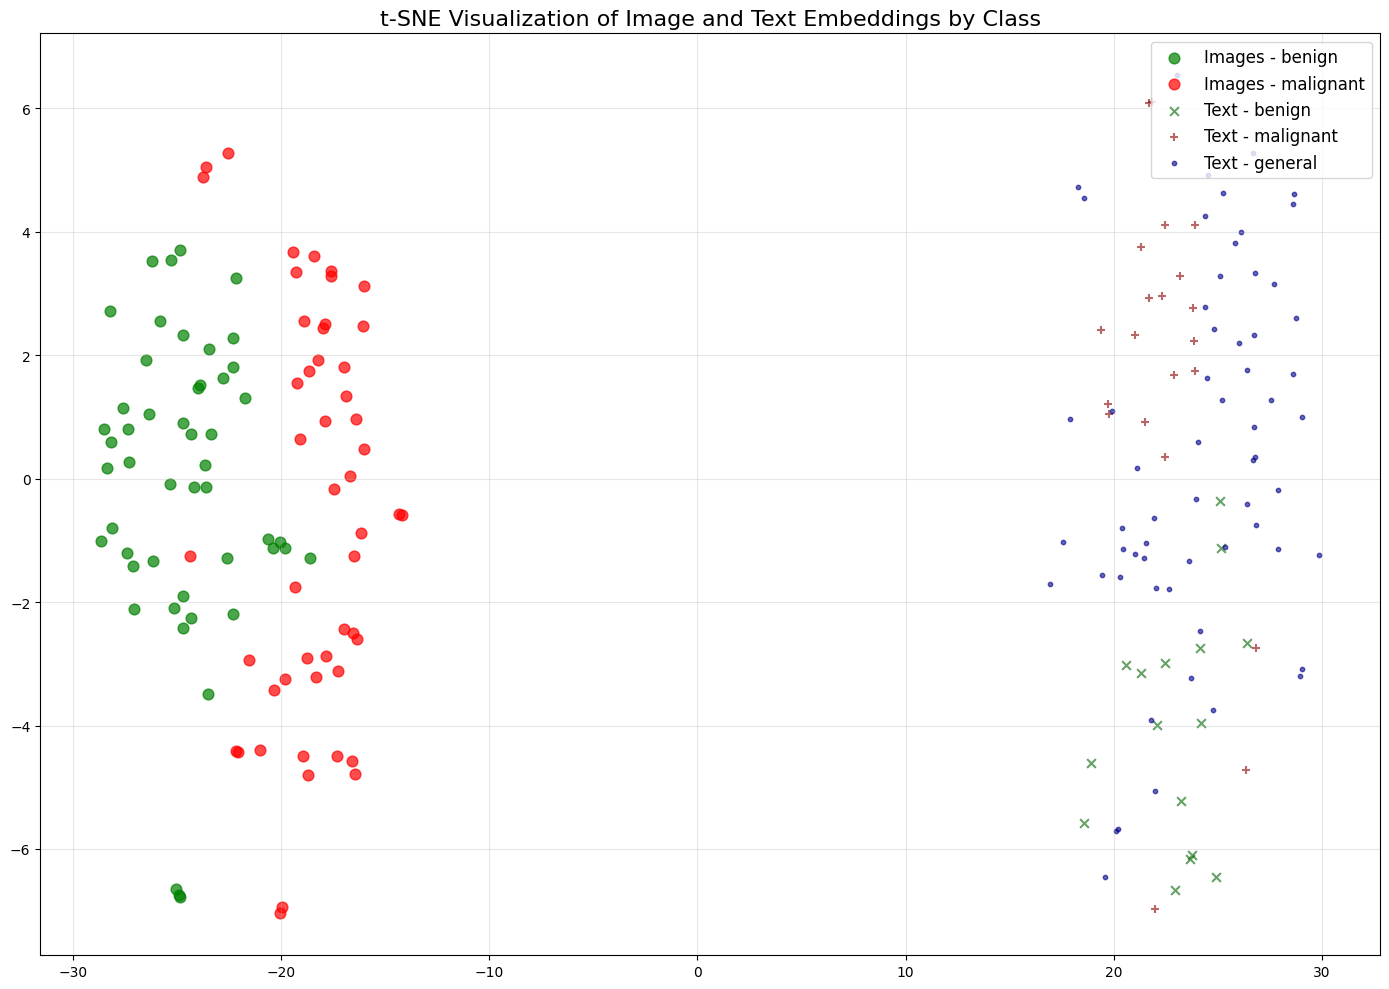


Analyzing similarity score distribution...


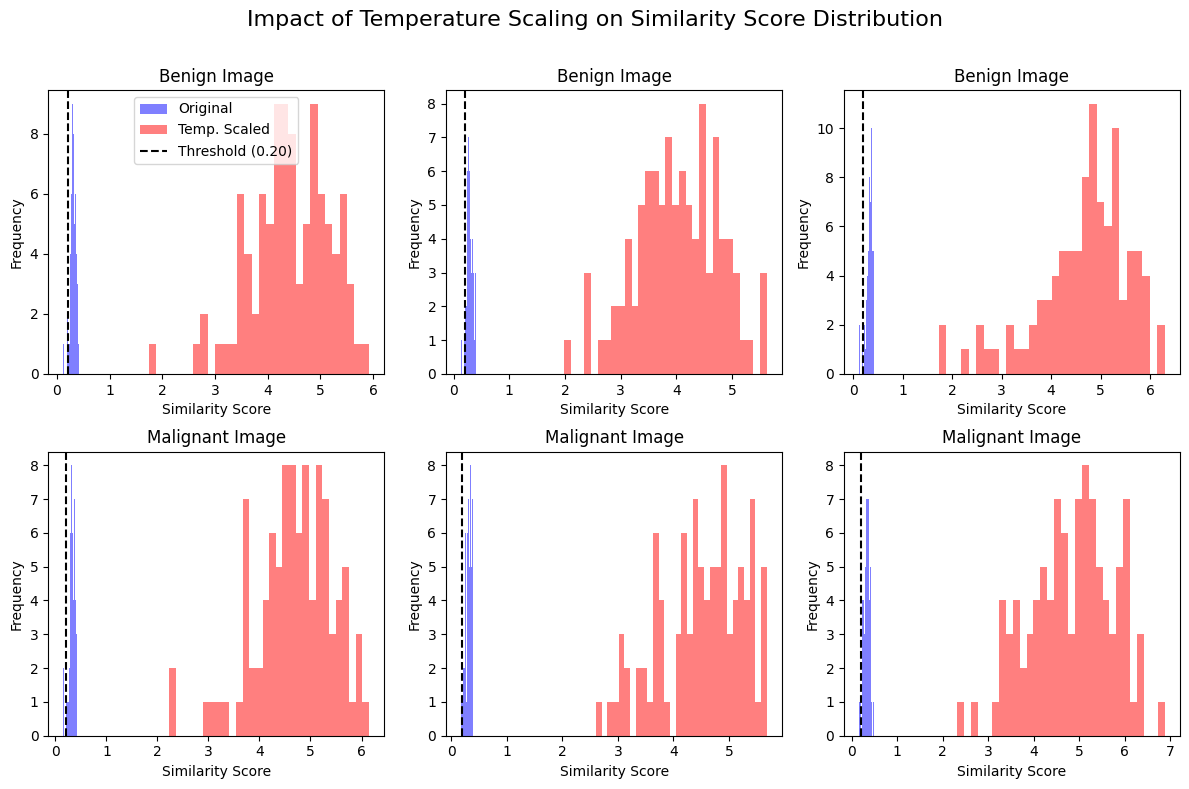


Generating image-caption pair visualizations...


C:\Users\BTBM\AppData\Local\Temp\ipykernel_16152\1164172722.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


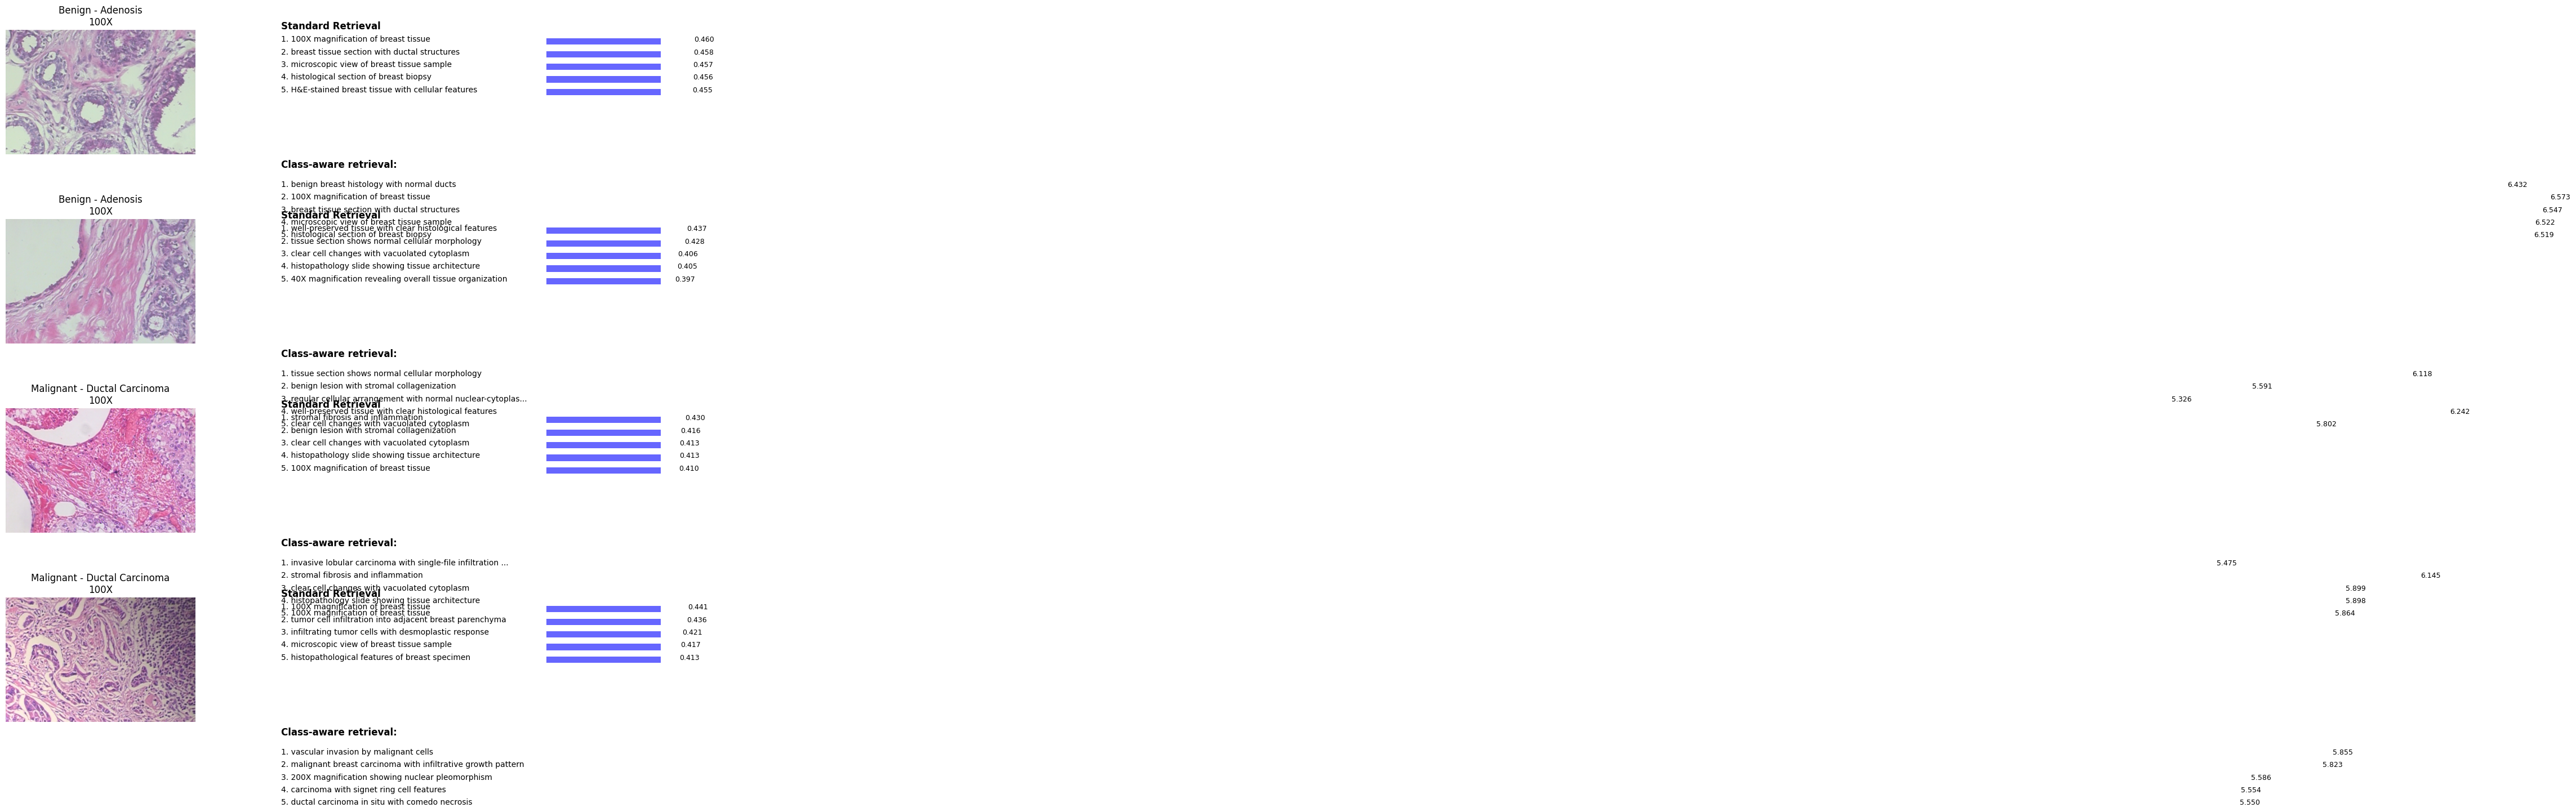


Generating similarity matrix visualization...


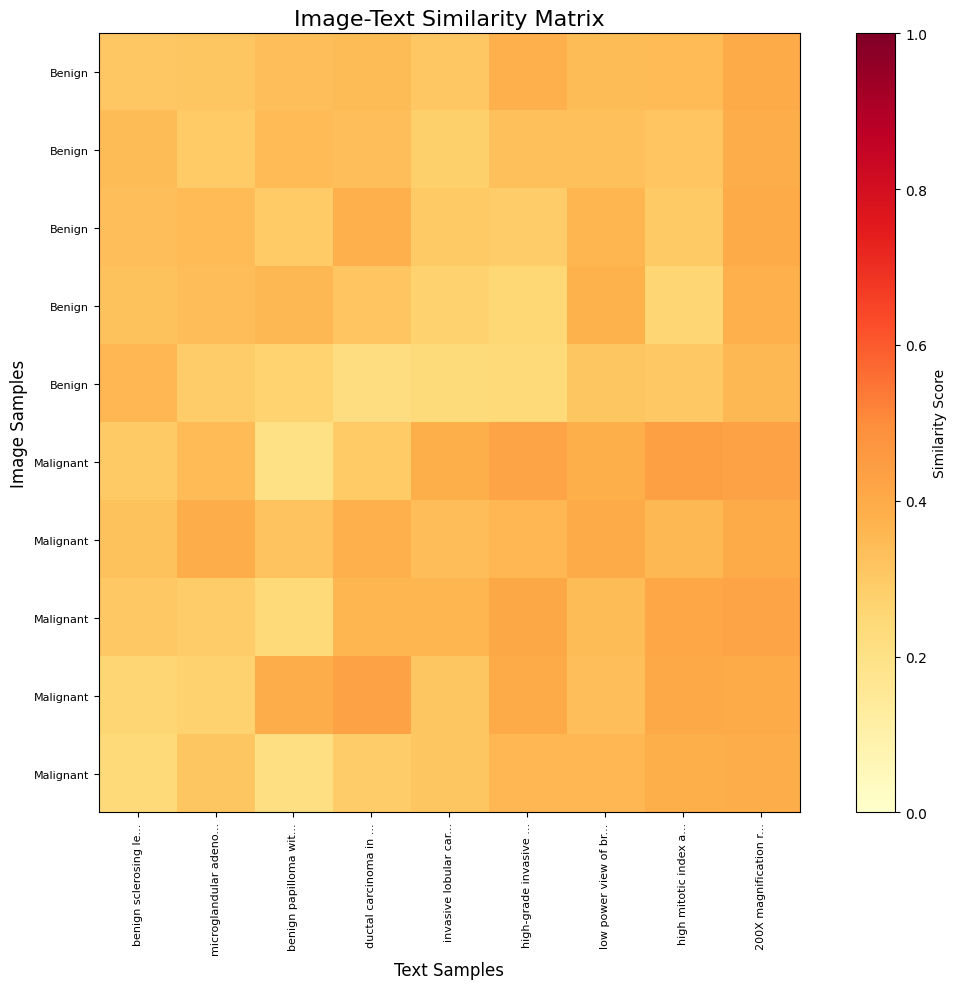


✓ Visualization complete


In [8]:
# Cell 8: Comprehensive Visualization of Embedding Space and Retrieval Results
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from PIL import Image
import random
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

print("=" * 60)
print("EMBEDDING SPACE VISUALIZATION AND ANALYSIS")
print("=" * 60)

# Define a function to create custom colormaps
def create_custom_cmap(name, colors):
    return LinearSegmentedColormap.from_list(name, colors)

# Create custom colormaps for different classes
benign_cmap = create_custom_cmap("benign_cmap", ["lightgreen", "darkgreen"])
malignant_cmap = create_custom_cmap("malignant_cmap", ["lightsalmon", "darkred"])

# 1. t-SNE Visualization of Embeddings
print("Generating t-SNE visualization of image and text embeddings...")

# Sample embeddings if there are too many (for faster computation)
MAX_TSNE_SAMPLES = 300

# Sample image embeddings
if len(image_embeddings) > MAX_TSNE_SAMPLES:
    # Try to get a balanced sample from both classes
    benign_indices = [i for i, p in enumerate(image_paths) if "benign" in p.lower()]
    malignant_indices = [i for i, p in enumerate(image_paths) if "malignant" in p.lower()]
    other_indices = [i for i, p in enumerate(image_paths) if "benign" not in p.lower() and "malignant" not in p.lower()]
    
    # Calculate how many samples to take from each class
    if benign_indices and malignant_indices:
        samples_per_class = MAX_TSNE_SAMPLES // 2
        
        # Sample from each class
        sampled_benign = random.sample(benign_indices, min(samples_per_class, len(benign_indices)))
        sampled_malignant = random.sample(malignant_indices, min(samples_per_class, len(malignant_indices)))
        
        # If we need more samples, take from other indices
        remaining = MAX_TSNE_SAMPLES - len(sampled_benign) - len(sampled_malignant)
        sampled_other = random.sample(other_indices, min(remaining, len(other_indices))) if remaining > 0 else []
        
        # Combine samples
        sampled_img_indices = sampled_benign + sampled_malignant + sampled_other
    else:
        # Simple random sampling if we can't detect classes
        sampled_img_indices = random.sample(range(len(image_embeddings)), MAX_TSNE_SAMPLES)
    
    # Extract sampled embeddings and paths
    sampled_img_embeddings = image_embeddings[sampled_img_indices]
    sampled_img_paths = [image_paths[i] for i in sampled_img_indices]
else:
    # Use all embeddings if there are few enough
    sampled_img_embeddings = image_embeddings
    sampled_img_paths = image_paths
    sampled_img_indices = list(range(len(image_paths)))

# Sample text embeddings
if len(text_embeddings) > MAX_TSNE_SAMPLES:
    # Organize by class
    text_by_class = organize_texts_by_class(corpus)
    
    # Calculate samples per class
    benign_texts = text_by_class["benign"]
    malignant_texts = text_by_class["malignant"]
    general_texts = text_by_class["general"]
    
    samples_per_class = MAX_TSNE_SAMPLES // 3
    
    # Sample from each class
    sampled_benign_texts = random.sample(benign_texts, min(samples_per_class, len(benign_texts)))
    sampled_malignant_texts = random.sample(malignant_texts, min(samples_per_class, len(malignant_texts)))
    
    # If we need more samples, take from general texts
    remaining = MAX_TSNE_SAMPLES - len(sampled_benign_texts) - len(sampled_malignant_texts)
    sampled_general_texts = random.sample(general_texts, min(remaining, len(general_texts))) if remaining > 0 else []
    
    # Combine samples
    sampled_text_indices = [idx for idx, _ in sampled_benign_texts + sampled_malignant_texts + sampled_general_texts]
    sampled_txt_embeddings = text_embeddings[sampled_text_indices]
    sampled_txt_corpus = [corpus[i] for i in sampled_text_indices]
    
    # Assign class labels to sampled texts
    sampled_txt_classes = []
    for i in sampled_text_indices:
        text = corpus[i].lower()
        if any(term in text for term in ["benign", "fibroadenoma", "adenosis"]):
            sampled_txt_classes.append("benign")
        elif any(term in text for term in ["malignant", "carcinoma", "invasive"]):
            sampled_txt_classes.append("malignant")
        else:
            sampled_txt_classes.append("general")
else:
    # Use all embeddings if there are few enough
    sampled_txt_embeddings = text_embeddings
    sampled_txt_corpus = corpus
    sampled_text_indices = list(range(len(corpus)))
    
    # Assign class labels
    sampled_txt_classes = []
    for text in sampled_txt_corpus:
        text = text.lower()
        if any(term in text for term in ["benign", "fibroadenoma", "adenosis"]):
            sampled_txt_classes.append("benign")
        elif any(term in text for term in ["malignant", "carcinoma", "invasive"]):
            sampled_txt_classes.append("malignant")
        else:
            sampled_txt_classes.append("general")

# Assign class labels to sampled images
sampled_img_classes = []
for path in sampled_img_paths:
    if "benign" in path.lower():
        sampled_img_classes.append("benign")
    elif "malignant" in path.lower():
        sampled_img_classes.append("malignant")
    else:
        sampled_img_classes.append("unknown")

# Combine embeddings for t-SNE
combined_embeddings = np.vstack([sampled_img_embeddings, sampled_txt_embeddings])
embedding_types = ["image"] * len(sampled_img_embeddings) + ["text"] * len(sampled_txt_embeddings)
embedding_classes = sampled_img_classes + sampled_txt_classes

# Perform t-SNE
print(f"Computing t-SNE for {len(combined_embeddings)} embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(combined_embeddings) // 5), 
            learning_rate="auto", init="pca")
embeddings_2d = tsne.fit_transform(combined_embeddings)

# Split back into image and text embeddings
img_embeddings_2d = embeddings_2d[:len(sampled_img_embeddings)]
txt_embeddings_2d = embeddings_2d[len(sampled_img_embeddings):]

# Visualization 1: t-SNE plot with class-based coloring
plt.figure(figsize=(14, 10))
plt.title("t-SNE Visualization of Image and Text Embeddings by Class", fontsize=16)

# Plot image points by class
for class_name, marker, color in [
    ("benign", "o", "green"),
    ("malignant", "o", "red"),
    ("unknown", "o", "gray")
]:
    indices = [i for i, c in enumerate(sampled_img_classes) if c == class_name]
    if indices:
        plt.scatter(
            img_embeddings_2d[indices, 0], 
            img_embeddings_2d[indices, 1],
            c=color, 
            marker=marker,
            alpha=0.7,
            s=60,
            label=f"Images - {class_name}"
        )

# Plot text points by class
for class_name, marker, color in [
    ("benign", "x", "darkgreen"),
    ("malignant", "+", "darkred"),
    ("general", ".", "darkblue")
]:
    indices = [i for i, c in enumerate(sampled_txt_classes) if c == class_name]
    if indices:
        plt.scatter(
            txt_embeddings_2d[indices, 0],
            txt_embeddings_2d[indices, 1],
            c=color,
            marker=marker,
            alpha=0.6,
            s=40,
            label=f"Text - {class_name}"
        )

plt.legend(loc="upper right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Similarity Score Distribution Analysis
print("\nAnalyzing similarity score distribution...")

# Pick a few random images from each class
benign_indices = [i for i, path in enumerate(image_paths) if "benign" in path.lower()]
malignant_indices = [i for i, path in enumerate(image_paths) if "malignant" in path.lower()]

if benign_indices and malignant_indices:
    # Sample images from each class
    sample_benign = random.sample(benign_indices, min(3, len(benign_indices)))
    sample_malignant = random.sample(malignant_indices, min(3, len(malignant_indices)))
    
    # Collect all sample indices
    all_samples = sample_benign + sample_malignant
    
    # For each sample, compute similarity with all text embeddings
    plt.figure(figsize=(12, 8))
    
    for i, sample_idx in enumerate(all_samples):
        img_embedding = image_embeddings[sample_idx]
        img_embedding_norm = img_embedding / np.linalg.norm(img_embedding)
        
        # Compute similarities
        similarities = np.dot(text_embeddings, img_embedding_norm)
        
        # Apply temperature scaling
        scaled_similarities = apply_temperature_scaling(similarities, temperature=CONFIG["TEMPERATURE"])
        
        # Get class



        img_class = "benign" if sample_idx in benign_indices else "malignant"
        
        # Plot histograms
        ax = plt.subplot(2, 3, i+1)
        plt.hist(similarities, bins=30, alpha=0.5, color='blue', label="Original")
        plt.hist(scaled_similarities, bins=30, alpha=0.5, color='red', label="Temp. Scaled")
        
        # Mark the similarity threshold
        plt.axvline(x=CONFIG["SIMILARITY_THRESHOLD"], color='black', linestyle='--', 
                    label=f"Threshold ({CONFIG['SIMILARITY_THRESHOLD']:.2f})")
        
        # Add title and labels
        plt.title(f"{img_class.capitalize()} Image", fontsize=12)
        plt.xlabel("Similarity Score")
        plt.ylabel("Frequency")
        
        # Only show legend for the first plot
        if i == 0:
            plt.legend()
    
    plt.suptitle("Impact of Temperature Scaling on Similarity Score Distribution", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# 3. Image-Caption Pair Visualization
print("\nGenerating image-caption pair visualizations...")

# Choose sample images for visualization (balance classes)
if benign_indices and malignant_indices:
    viz_samples = []
    viz_samples.extend(random.sample(benign_indices, min(2, len(benign_indices))))
    viz_samples.extend(random.sample(malignant_indices, min(2, len(malignant_indices))))
else:
    # If we can't detect classes, use random samples
    viz_samples = random.sample(range(len(image_paths)), min(4, len(image_paths)))

# Visualization function for image-caption pairs
def visualize_image_caption_pairs(sample_indices, use_improved_index=False):
    """Visualize image-caption pairs with similarity scores"""
    n_samples = len(sample_indices)
    fig = plt.figure(figsize=(15, 4 * n_samples))
    
    # Create grid layout
    gs = gridspec.GridSpec(n_samples, 2, width_ratios=[1, 2], wspace=0.3, hspace=0.5)
    
    # Process each sample
    for i, idx in enumerate(sample_indices):
        # Get image path and embedding
        img_path = image_paths[idx]
        img_emb = image_embeddings[idx]
        
        # Extract metadata and class
        metadata = extract_breakhis_metadata(img_path)
        img_class = metadata.get('tumor_class', 'Unknown')
        
        # Create normalized embedding for standard retrieval
        img_emb_norm = img_emb / np.linalg.norm(img_emb)
        
        # Display image
        ax_img = fig.add_subplot(gs[i, 0])
        img = Image.open(img_path).convert("RGB")
        ax_img.imshow(img)
        ax_img.set_title(f"{img_class} - {metadata.get('tumor_type', 'Unknown')}\n{metadata.get('magnification', '')}", fontsize=12)
        ax_img.axis('off')
        
        # Display captions
        ax_caption = fig.add_subplot(gs[i, 1])
        
        if use_improved_index and 'improved_index' in globals() and 'improved_img_embeddings' in globals():
            # Use improved embeddings and index
            D, I = improved_index.search(np.array([improved_img_embeddings[idx]]).astype('float32'), 5)
            caption_title = "Fine-tuned Embeddings"
        else:
            # Use standard retrieval
            D, I = index.search(np.array([img_emb_norm]).astype('float32'), 5)
            caption_title = "Standard Retrieval"
            
            # Also show class-aware retrieval
            class_aware_results = class_aware_retrieval(
                img_emb, text_embeddings, corpus, metadata, top_k=5, temperature=CONFIG["TEMPERATURE"]
            )
            
            # Add labels to show class-aware results
            ax_caption.text(0, -0.1, "Class-aware retrieval:", fontsize=12, weight='bold', transform=ax_caption.transAxes)
            
            for rank, (text, _, adj_score) in enumerate(class_aware_results):
                # Truncate text if it's too long
                display_text = text if len(text) < 60 else text[:57] + "..."
                ax_caption.text(0, -0.25 - 0.1 * rank, f"{rank+1}. {display_text}", fontsize=10, transform=ax_caption.transAxes)
                # Add score bar
                score_bar_length = adj_score * 0.8  # Scale to fit
                ax_caption.barh(-0.25 - 0.1 * rank, score_bar_length, 0.05, left=0.7, 
                           color='red', alpha=0.6, transform=ax_caption.transAxes)
                ax_caption.text(0.7 + score_bar_length + 0.02, -0.25 - 0.1 * rank, f"{adj_score:.3f}", 
                           fontsize=9, transform=ax_caption.transAxes)
            
        # Display standard retrieval results
        ax_caption.text(0, 1.0, caption_title, fontsize=12, weight='bold', transform=ax_caption.transAxes)
        
        # Show each caption with score
        for rank, (idx, score) in enumerate(zip(I[0], D[0])):
            # Get text and truncate if needed
            text = corpus[int(idx)]
            display_text = text if len(text) < 60 else text[:57] + "..."
            
            # Add text
            ax_caption.text(0, 0.9 - 0.1 * rank, f"{rank+1}. {display_text}", fontsize=10, transform=ax_caption.transAxes)
            
            # Add score bar
            score_bar_length = score * 0.8  # Scale to fit
            ax_caption.barh(0.9 - 0.1 * rank, score_bar_length, 0.05, left=0.7, 
                       color='blue', alpha=0.6, transform=ax_caption.transAxes)
            ax_caption.text(0.7 + score_bar_length + 0.02, 0.9 - 0.1 * rank, f"{score:.3f}", 
                       fontsize=9, transform=ax_caption.transAxes)
        
        # Turn off axes for the caption subplot
        ax_caption.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize standard retrieval results
visualize_image_caption_pairs(viz_samples)

# If improved embeddings exist, visualize with those too
if 'improved_index' in globals() and 'improved_img_embeddings' in globals():
    print("\nVisualizing results with fine-tuned embeddings...")
    visualize_image_caption_pairs(viz_samples, use_improved_index=True)

# 4. Similarity Matrix Visualization (between samples)
print("\nGenerating similarity matrix visualization...")

# Sample a small number of images and texts for the matrix
matrix_samples = 10
matrix_img_indices = []
matrix_txt_indices = []

# Get balanced samples if possible
if benign_indices and malignant_indices:
    matrix_img_indices.extend(random.sample(benign_indices, min(matrix_samples//2, len(benign_indices))))
    matrix_img_indices.extend(random.sample(malignant_indices, min(matrix_samples//2, len(malignant_indices))))
    
    # Ensure we have exactly matrix_samples images
    if len(matrix_img_indices) < matrix_samples:
        remaining = matrix_samples - len(matrix_img_indices)
        additional_indices = random.sample([i for i in range(len(image_paths)) if i not in matrix_img_indices], 
                                        min(remaining, len(image_paths) - len(matrix_img_indices)))
        matrix_img_indices.extend(additional_indices)
else:
    matrix_img_indices = random.sample(range(len(image_paths)), min(matrix_samples, len(image_paths)))

# Get text samples from different categories
text_by_class = organize_texts_by_class(corpus)
if text_by_class["benign"] and text_by_class["malignant"]:
    # Get balanced text samples
    benign_txt_samples = random.sample(text_by_class["benign"], min(matrix_samples//3, len(text_by_class["benign"])))
    malignant_txt_samples = random.sample(text_by_class["malignant"], min(matrix_samples//3, len(text_by_class["malignant"])))
    general_txt_samples = random.sample(text_by_class["general"], min(matrix_samples//3, len(text_by_class["general"])))
    
    # Extract indices
    matrix_txt_indices = [idx for idx, _ in benign_txt_samples + malignant_txt_samples + general_txt_samples]
else:
    matrix_txt_indices = random.sample(range(len(corpus)), min(matrix_samples, len(corpus)))

# Compute similarity matrix
img_embeddings_norm = image_embeddings[matrix_img_indices]
for i in range(len(img_embeddings_norm)):
    img_embeddings_norm[i] = img_embeddings_norm[i] / np.linalg.norm(img_embeddings_norm[i])

txt_embeddings_norm = text_embeddings[matrix_txt_indices]
for i in range(len(txt_embeddings_norm)):
    txt_embeddings_norm[i] = txt_embeddings_norm[i] / np.linalg.norm(txt_embeddings_norm[i])

# Compute similarity matrix
similarity_matrix = np.dot(img_embeddings_norm, txt_embeddings_norm.T)

# Plot similarity matrix
plt.figure(figsize=(12, 10))
plt.imshow(similarity_matrix, cmap="YlOrRd", vmin=0, vmax=1)
plt.colorbar(label="Similarity Score")
plt.title("Image-Text Similarity Matrix", fontsize=16)
plt.xlabel("Text Samples", fontsize=12)
plt.ylabel("Image Samples", fontsize=12)

# Add axis labels
img_labels = []
for idx in matrix_img_indices:
    metadata = extract_breakhis_metadata(image_paths[idx])
    img_labels.append(f"{metadata.get('tumor_class', 'Unknown')}")

txt_labels = []
for idx in matrix_txt_indices:
    text = corpus[idx]
    # Truncate text for display
    txt_labels.append(text[:20] + "..." if len(text) > 20 else text)

plt.xticks(range(len(txt_labels)), txt_labels, rotation=90, fontsize=8)
plt.yticks(range(len(img_labels)), img_labels, fontsize=8)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

# Quantitative Evaluation and Metrics

This section provides quantitative evaluation of retrieval performance using various metrics.

## Key Features

- **Precision@K**: Measures precision at different K values
- **Class Accuracy**: Evaluates how well retrievals match the correct class
- **Confidence Score Analysis**: Analyzes the distribution of confidence scores
- **Cross-validation**: Evaluates performance across different subsets of data

## Getting Started

Run this cell to evaluate the retrieval performance. This provides objective measurements of the pipeline's quality.

RETRIEVAL PERFORMANCE EVALUATION
Evaluating standard retrieval performance...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Standard Retrieval Results:
Top-1 retrievals:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
Top-3 retrievals:
  Accuracy: 0.5000
  Precision: 0.3333
  Recall: 0.5000
  F1-score: 0.4000
Top-5 retrievals:
  Accuracy: 0.5000
  Precision: 0.3000
  Recall: 0.5000
  F1-score: 0.3750

Evaluating class-aware retrieval performance...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Class-aware Retrieval Results:
Top-1 retrievals:
  Accuracy: 0.4300
  Precision: 0.4300
  Recall: 0.4300
  F1-score: 0.4300
Top-3 retrievals:
  Accuracy: 0.8000
  Precision: 0.5267
  Recall: 0.8000
  F1-score: 0.6352
Top-5 retrievals:
  Accuracy: 0.9300
  Precision: 0.5760
  Recall: 0.9300
  F1-score: 0.7114


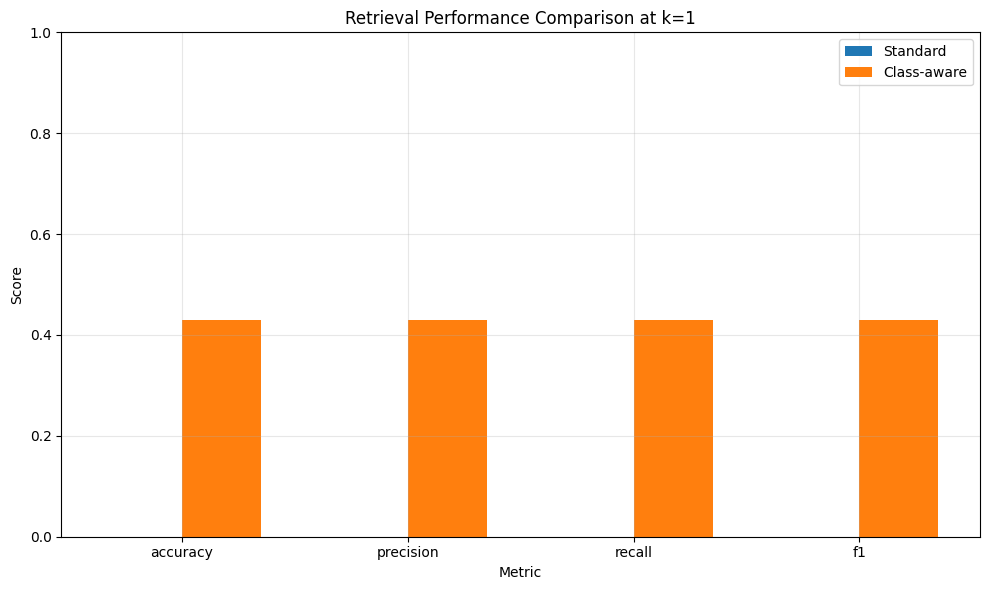

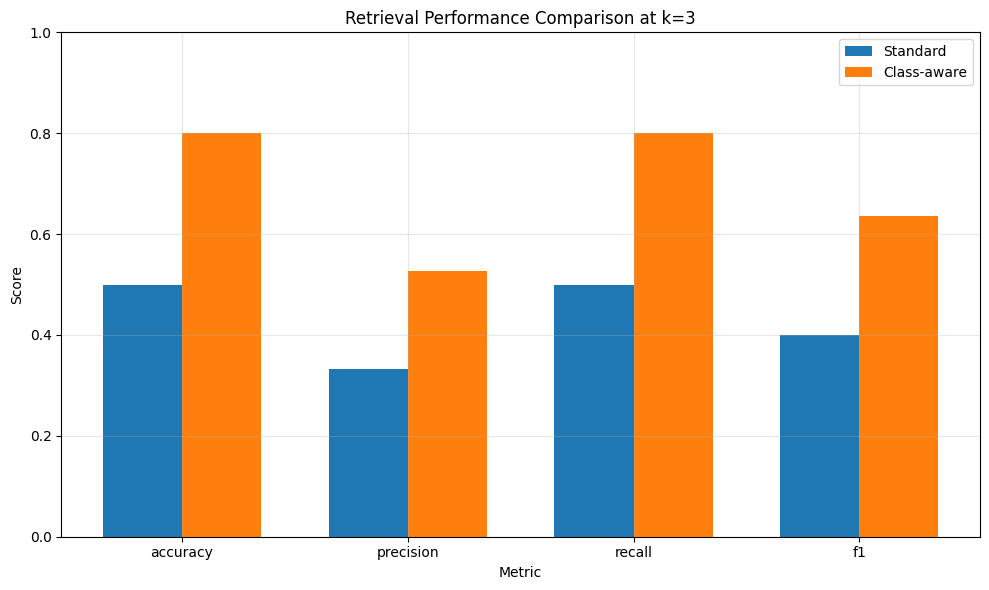

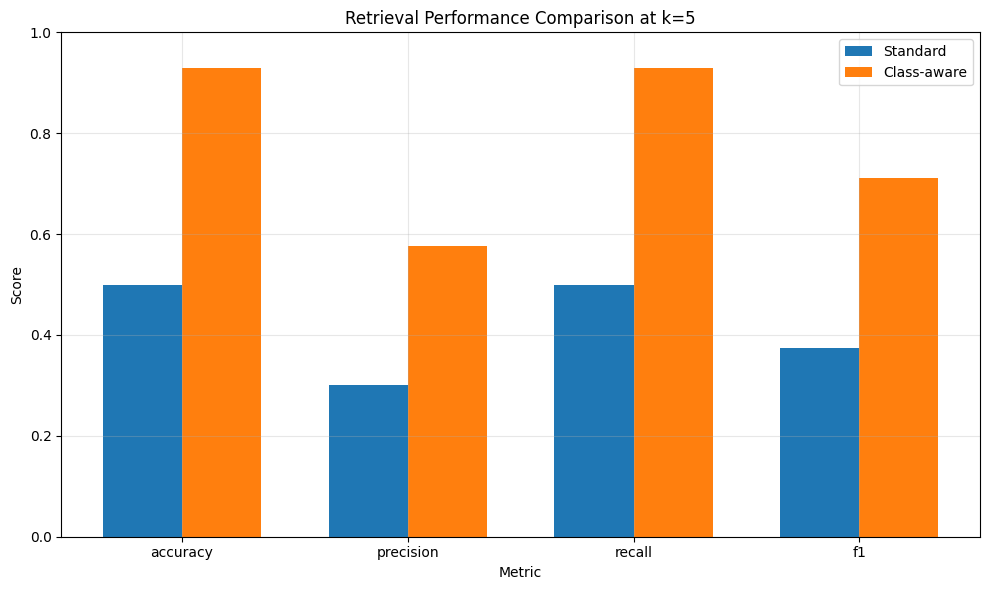

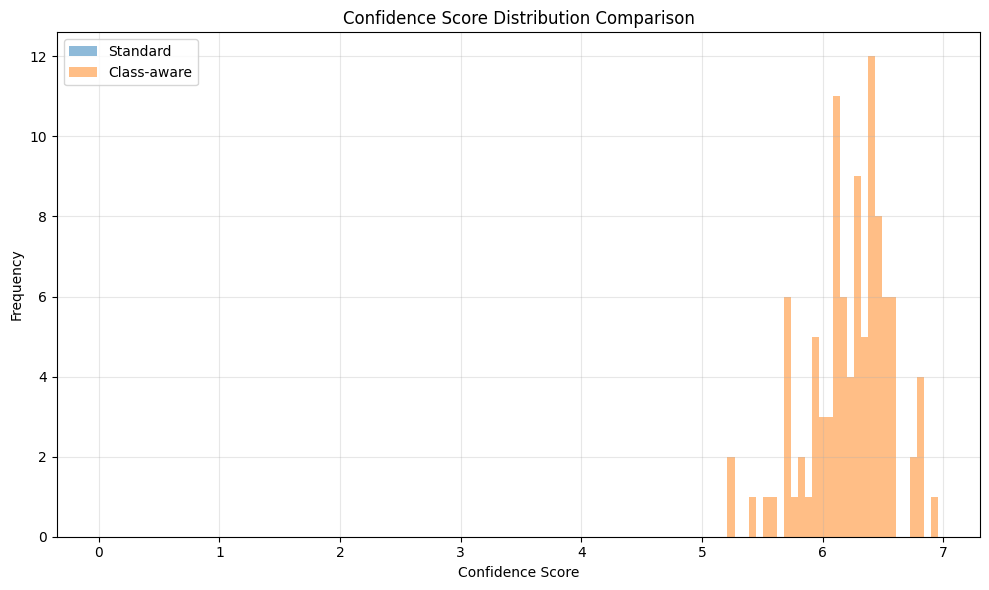


✓ Evaluation complete


In [9]:
# Cell 9: Quantitative Evaluation and Metrics
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

print("=" * 60)
print("RETRIEVAL PERFORMANCE EVALUATION")
print("=" * 60)

# Helper function to extract class from text
def extract_class_from_text(text):
    text = text.lower()
    if any(term in text for term in ["benign", "fibroadenoma", "adenosis", "normal", "hyperplasia"]):
        return "benign"
    elif any(term in text for term in ["malignant", "carcinoma", "invasive", "ductal carcinoma", "pleomorphism"]):
        return "malignant"
    return "unknown"

# Helper function to extract class from image path
def extract_class_from_path(path):
    if "benign" in path.lower():
        return "benign"
    elif "malignant" in path.lower():
        return "malignant"
    return "unknown"

# Define evaluation function for retrieval metrics
def evaluate_retrieval(image_paths, image_embeddings, text_embeddings, corpus, k_values=[1, 3, 5]):
    """Evaluate retrieval performance with various metrics"""
    results = {k: {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0} for k in k_values}
    
    # Initialize confusion matrices for each k
    confusion_matrices = {k: {"tp": 0, "fp": 0, "tn": 0, "fn": 0} for k in k_values}
    
    # Track confidence scores
    confidence_scores = []
    
    # Process each image
    for i, (path, embedding) in enumerate(tqdm(zip(image_paths, image_embeddings), desc="Evaluating", total=len(image_paths))):
        # Get true class
        true_class = extract_class_from_path(path)
        if true_class == "unknown":
            continue  # Skip images without clear class
        
        # Normalize embedding
        norm_embedding = embedding / np.linalg.norm(embedding)
        
        # For each k value
        for k in k_values:
            # Get top k indices
            top_k_indices = np.argsort(-similarities)[:k]
            
            # Get retrieved texts and their classes
            retrieved_texts = [corpus[idx] for idx in top_k_indices]
            retrieved_classes = [extract_class_from_text(text) for text in retrieved_texts]
            
            # Check if we have at least one correct class prediction
            correct_preds = [cls == true_class for cls in retrieved_classes]
            
            # Calculate accuracy (was the correct class retrieved at all?)
            results[k]["accuracy"] += 1 if any(correct_preds) else 0
            
            # Calculate precision (what portion of retrievals match true class?)
            precision = sum(1 for cls in retrieved_classes if cls == true_class) / k
            results[k]["precision"] += precision
            
            # Update confusion matrix
            if any(correct_preds):
                confusion_matrices[k]["tp"] += 1  # true positive
            else:
                confusion_matrices[k]["fn"] += 1  # false negative
            
    # Calculate final metrics
    n_samples = sum(1 for path in image_paths if extract_class_from_path(path) != "unknown")
    
    for k in k_values:
        results[k]["accuracy"] /= n_samples
        results[k]["precision"] /= n_samples
        
        # Calculate recall and F1 from confusion matrix
        tp = confusion_matrices[k]["tp"]
        fn = confusion_matrices[k]["fn"]
        
        results[k]["recall"] = tp / (tp + fn) if (tp + fn) > 0 else 0
        results[k]["f1"] = 2 * results[k]["precision"] * results[k]["recall"] / (results[k]["precision"] + results[k]["recall"]) \
                            if (results[k]["precision"] + results[k]["recall"]) > 0 else 0
    
    return results, confidence_scores

# Evaluate standard retrieval
print("Evaluating standard retrieval performance...")
std_results, std_confidence_scores = evaluate_retrieval(image_paths, image_embeddings, text_embeddings, corpus)

# Print standard retrieval results
print("\nStandard Retrieval Results:")
for k, metrics in std_results.items():
    print(f"Top-{k} retrievals:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-score: {metrics['f1']:.4f}")

# Evaluate class-aware retrieval if available
print("\nEvaluating class-aware retrieval performance...")

# Function to evaluate with class-aware retrieval
def evaluate_class_aware(image_paths, image_embeddings, text_embeddings, corpus, k_values=[1, 3, 5]):
    """Evaluate retrieval with class-aware reranking"""
    results = {k: {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0} for k in k_values}
    confidence_scores = []
    
    # Initialize confusion matrices for each k
    confusion_matrices = {k: {"tp": 0, "fp": 0, "tn": 0, "fn": 0} for k in k_values}
    
    # Process each image
    for i, (path, embedding) in enumerate(tqdm(zip(image_paths, image_embeddings), desc="Evaluating", total=len(image_paths))):
        # Get true class and metadata
        true_class = extract_class_from_path(path)
        if true_class == "unknown":
            continue  # Skip images without clear class
        
        metadata = extract_breakhis_metadata(path)
        
        # For each k value
        for k in k_values:
            # Get class-aware retrieval results
            results_k = class_aware_retrieval(
                embedding, text_embeddings, corpus, metadata, 
                top_k=k, temperature=CONFIG["TEMPERATURE"]
            )
            
            # Record the top confidence score
            if k == 1:
                confidence_scores.append(results_k[0][2])  # adjusted score
            
            # Get retrieved texts and their classes
            retrieved_texts = [text for text, _, _ in results_k]
            retrieved_classes = [extract_class_from_text(text) for text in retrieved_texts]
            
            # Check if we have at least one correct class prediction
            correct_preds = [cls == true_class for cls in retrieved_classes]
            
            # Calculate accuracy (was the correct class retrieved at all?)
            results[k]["accuracy"] += 1 if any(correct_preds) else 0
            
            # Calculate precision (what portion of retrievals match true class?)
            precision = sum(1 for cls in retrieved_classes if cls == true_class) / k
            results[k]["precision"] += precision
            
            # Update confusion matrix
            if any(correct_preds):
                confusion_matrices[k]["tp"] += 1  # true positive
            else:
                confusion_matrices[k]["fn"] += 1  # false negative
    
    # Calculate final metrics
    n_samples = sum(1 for path in image_paths if extract_class_from_path(path) != "unknown")
    
    for k in k_values:
        results[k]["accuracy"] /= n_samples
        results[k]["precision"] /= n_samples
        
        # Calculate recall and F1 from confusion matrix
        tp = confusion_matrices[k]["tp"]
        fn = confusion_matrices[k]["fn"]
        
        results[k]["recall"] = tp / (tp + fn) if (tp + fn) > 0 else 0
        results[k]["f1"] = 2 * results[k]["precision"] * results[k]["recall"] / (results[k]["precision"] + results[k]["recall"]) \
                            if (results[k]["precision"] + results[k]["recall"]) > 0 else 0
    
    return results, confidence_scores

# Run class-aware evaluation
ca_results, ca_confidence_scores = evaluate_class_aware(image_paths, image_embeddings, text_embeddings, corpus)

# Print class-aware retrieval results
print("\nClass-aware Retrieval Results:")
for k, metrics in ca_results.items():
    print(f"Top-{k} retrievals:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-score: {metrics['f1']:.4f}")

# Evaluate improved/fine-tuned retrieval if available
if 'improved_index' in globals() and 'improved_img_embeddings' in globals():
    print("\nEvaluating fine-tuned retrieval performance...")
    
    # Function to evaluate with improved embeddings
    def evaluate_improved(image_paths, img_embeddings, txt_embeddings, corpus, index, k_values=[1, 3, 5]):
        """Evaluate retrieval with improved embeddings"""
        results = {k: {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0} for k in k_values}
        confidence_scores = []
        
        # Initialize confusion matrices for each k
        confusion_matrices = {k: {"tp": 0, "fp": 0, "tn": 0, "fn": 0} for k in k_values}
        
        # Process each image
        for i, path in enumerate(tqdm(image_paths, desc="Evaluating", total=len(image_paths))):
            # Get true class
            true_class = extract_class_from_path(path)
            if true_class == "unknown":
                continue  # Skip images without clear class
            
            # Get image embedding
            embedding = img_embeddings[i]
            
            # For each k value
            for k in k_values:
                # Perform search with improved index
                D, I = index.search(np.array([embedding]).astype('float32'), k)
                
                # Record the top confidence score
                if k == 1:
                    confidence_scores.append(D[0][0])
                
                # Get retrieved texts and their classes
                retrieved_texts = [corpus[int(idx)] for idx in I[0]]
                retrieved_classes = [extract_class_from_text(text) for text in retrieved_texts]
                
                # Check if we have at least one correct class prediction
                correct_preds = [cls == true_class for cls in retrieved_classes]
                
                # Calculate accuracy (was the correct class retrieved at all?)
                results[k]["accuracy"] += 1 if any(correct_preds) else 0
                
                # Calculate precision (what portion of retrievals match true class?)
                precision = sum(1 for cls in retrieved_classes if cls == true_class) / k
                results[k]["precision"] += precision
                
                # Update confusion matrix
                if any(correct_preds):
                    confusion_matrices[k]["tp"] += 1  # true positive
                else:
                    confusion_matrices[k]["fn"] += 1  # false negative
        
        # Calculate final metrics
        n_samples = sum(1 for path in image_paths if extract_class_from_path(path) != "unknown")
        
        for k in k_values:
            results[k]["accuracy"] /= n_samples
            results[k]["precision"] /= n_samples
            
            # Calculate recall and F1 from confusion matrix
            tp = confusion_matrices[k]["tp"]
            fn = confusion_matrices[k]["fn"]
            
            results[k]["recall"] = tp / (tp + fn) if (tp + fn) > 0 else 0
            results[k]["f1"] = 2 * results[k]["precision"] * results[k]["recall"] / (results[k]["precision"] + results[k]["recall"]) \
                                if (results[k]["precision"] + results[k]["recall"]) > 0 else 0
        
        return results, confidence_scores
    
    # Evaluate improved embeddings
    ft_results, ft_confidence_scores = evaluate_improved(
        image_paths, improved_img_embeddings, improved_txt_embeddings, corpus, improved_index
    )
    
    # Print fine-tuned retrieval results
    print("\nFine-tuned Retrieval Results:")
    for k, metrics in ft_results.items():
        print(f"Top-{k} retrievals:")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1']:.4f}")
    
    # Plot comparison of all methods
    k_values = list(std_results.keys())
    
    # Prepare data for plotting
    methods = ["Standard", "Class-aware", "Fine-tuned"]
    metrics = ["accuracy", "precision", "recall", "f1"]
    
    # Create plots for each k value
    for k in k_values:
        plt.figure(figsize=(12, 6))
        
        # Prepare data
        data = {
            "Standard": [std_results[k][metric] for metric in metrics],
            "Class-aware": [ca_results[k][metric] for metric in metrics],
            "Fine-tuned": [ft_results[k][metric] for metric in metrics]
        }
        
        # Create bar plot
        x = np.arange(len(metrics))
        width = 0.25
        
        for i, (method, values) in enumerate(data.items()):
            plt.bar(x + i*width, values, width, label=method)
        
        plt.xlabel('Metric')
        plt.ylabel('Score')
        plt.title(f'Retrieval Performance Comparison at k={k}')
        plt.xticks(x + width/2, metrics)
        plt.ylim(0, 1.0)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Confidence score comparison
    plt.figure(figsize=(10, 6))
    plt.hist(std_confidence_scores, bins=30, alpha=0.5, label='Standard')
    plt.hist(ca_confidence_scores, bins=30, alpha=0.5, label='Class-aware')
    plt.hist(ft_confidence_scores, bins=30, alpha=0.5, label='Fine-tuned')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Score Distribution Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    # Plot comparison of standard vs class-aware methods only
    k_values = list(std_results.keys())
    
    # Prepare data for plotting
    methods = ["Standard", "Class-aware"]
    metrics = ["accuracy", "precision", "recall", "f1"]
    
    # Create plots for each k value
    for k in k_values:
        plt.figure(figsize=(10, 6))
        
        # Prepare data
        data = {
            "Standard": [std_results[k][metric] for metric in metrics],
            "Class-aware": [ca_results[k][metric] for metric in metrics]
        }
        
        # Create bar plot
        x = np.arange(len(metrics))
        width = 0.35
        
        for i, (method, values) in enumerate(data.items()):
            plt.bar(x + i*width, values, width, label=method)
        
        plt.xlabel('Metric')
        plt.ylabel('Score')
        plt.title(f'Retrieval Performance Comparison at k={k}')
        plt.xticks(x + width/2, metrics)
        plt.ylim(0, 1.0)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Confidence score comparison
    plt.figure(figsize=(10, 6))
    plt.hist(std_confidence_scores, bins=30, alpha=0.5, label='Standard')
    plt.hist(ca_confidence_scores, bins=30, alpha=0.5, label='Class-aware')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Score Distribution Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✓ Evaluation complete")

# Integrated Pipeline for High-Confidence Image Captioning

This section provides a complete end-to-end pipeline for high-confidence medical image captioning, bringing together all the components we've built.

## Key Features

- **Unified Interface**: Process new images with a simple API
- **Multiple Retrieval Methods**: Choose between standard, class-aware, and fine-tuned retrieval
- **Confidence Filtering**: Filter results by confidence score
- **Interactive UI**: User-friendly interface with visualizations
- **Batch Processing**: Efficiently process multiple images

## Getting Started

Run this cell to initialize the integrated pipeline. You can then use the provided functions and UI to process new images and retrieve captions.

In [ ]:
# Cell 10: Integrated Pipeline for High-Confidence Image Captioning
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import random
import time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

print("=" * 60)
print("INTEGRATED IMAGE CAPTIONING PIPELINE")
print("=" * 60)

# Unified image captioning pipeline
class MedicalImageCaptioningPipeline:
    """End-to-end pipeline for high-confidence medical image captioning"""
    
    def __init__(self, model, preprocess, corpus, text_embeddings, index,
                 improved_embeddings=None, improved_txt_embeddings=None, improved_index=None):
        """Initialize the pipeline with model and data"""
        self.model = model
        self.preprocess = preprocess
        self.corpus = corpus
        self.text_embeddings = text_embeddings
        self.index = index
        self.improved_img_embeddings = improved_embeddings
        self.improved_txt_embeddings = improved_txt_embeddings
        self.improved_index = improved_index
        
        # Configure device
        self.device = next(model.parameters()).device
        
        # Set default parameters
        self.temperature = CONFIG["TEMPERATURE"]
        self.top_k = CONFIG["TOP_K"]
        self.min_confidence = CONFIG["SIMILARITY_THRESHOLD"]
        self.available_methods = ["standard"]
        
        # Check which methods are available
        if self.improved_index is not None and self.improved_txt_embeddings is not None:
            self.available_methods.append("fine-tuned")
        
        # Class-aware retrieval is always available since it uses metadata
        self.available_methods.append("class-aware")
        self.available_methods.append("ensemble")
        
        print(f"✓ Pipeline initialized with {len(self.corpus)} text prompts")
        print(f"  Available retrieval methods: {', '.join(self.available_methods)}")
        
    def process_image(self, image_path, method="standard", metadata=None):
        """Process a single image and return captions with confidence scores"""
        # Load and preprocess the image
        try:
            if isinstance(image_path, (str, Path)):
                img = Image.open(image_path).convert("RGB")
            else:
                # Assume it's already a PIL image
                img = image_path.convert("RGB")
        except Exception as e:
            return {"error": f"Failed to open image: {str(e)}"}
            
        # Extract metadata if not provided
        if metadata is None and isinstance(image_path, (str, Path)):
            metadata = extract_breakhis_metadata(image_path)
        
        # Compute image embedding
        img_embedding = self.compute_embedding(img)
        
        # Retrieve captions using the specified method
        if method == "standard":
            results = self.standard_retrieval(img_embedding)
        elif method == "class-aware" and metadata:
            results = self.class_aware_retrieval(img_embedding, metadata)
        elif method == "fine-tuned" and self.improved_index is not None:
            results = self.fine_tuned_retrieval(img_embedding)
        elif method == "ensemble" and metadata:
            results = self.ensemble_retrieval(img_embedding, metadata)
        else:
            # Fallback to standard if method is not available
            print(f"Method '{method}' not available. Using standard retrieval.")
            results = self.standard_retrieval(img_embedding)
        
        # Filter by minimum confidence
        results = [r for r in results if r["confidence"] >= self.min_confidence]
        
        return {
            "image": img,
            "embedding": img_embedding,
            "metadata": metadata,
            "captions": results,
            "method": method
        }
    
    def compute_embedding(self, img):
        """Compute embedding for a single image"""
        self.model.eval()
        img_tensor = self.preprocess(img).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            features = self.model.encode_image(img_tensor)
            features = features / features.norm(dim=-1, keepdim=True)
            
        return features.cpu().numpy()[0]
    
    def standard_retrieval(self, img_embedding):
        """Perform standard FAISS retrieval"""
        # Normalize embedding
        img_emb_norm = img_embedding / np.linalg.norm(img_embedding)
        
        # Search the index
        D, I = self.index.search(np.array([img_emb_norm]).astype('float32'), self.top_k)
        
        # Format results
        results = []
        for i, (idx, score) in enumerate(zip(I[0], D[0])):
            results.append({
                "caption": self.corpus[int(idx)],
                "confidence": float(score),
                "rank": i + 1,
                "class": extract_class_from_text(self.corpus[int(idx)])
            })
        
        return results
    
    def class_aware_retrieval(self, img_embedding, metadata):
        """Perform class-aware retrieval with reranking"""
        # Get class-aware results
        raw_results = class_aware_retrieval(
            img_embedding, self.text_embeddings, self.corpus, 
            metadata, top_k=self.top_k, temperature=self.temperature
        )
        
        # Format results
        results = []
        for i, (text, orig_score, adj_score) in enumerate(raw_results):
            results.append({
                "caption": text,
                "confidence": float(adj_score),
                "original_confidence": float(orig_score),
                "rank": i + 1,
                "class": extract_class_from_text(text)
            })
        
        return results
    
    def fine_tuned_retrieval(self, img_embedding):
        """Perform retrieval with fine-tuned embeddings"""
        if not hasattr(self, 'img_projector') or self.img_projector is None:
            # No projector available, use embedding directly with improved index
            D, I = self.improved_index.search(np.array([img_embedding]).astype('float32'), self.top_k)
        else:
            # Project the embedding using fine-tuned projector
            img_emb_tensor = torch.tensor(img_embedding, dtype=torch.float32).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                projected = self.img_projector(img_emb_tensor).cpu().numpy()[0]
                
            # Search with projected embedding
            D, I = self.improved_index.search(np.array([projected]).astype('float32'), self.top_k)
        
        # Format results
        results = []
        for i, (idx, score) in enumerate(zip(I[0], D[0])):
            results.append({
                "caption": self.corpus[int(idx)],
                "confidence": float(score),
                "rank": i + 1,
                "class": extract_class_from_text(self.corpus[int(idx)])
            })
        
        return results
    
    def ensemble_retrieval(self, img_embedding, metadata):
        """Combine multiple retrieval methods for best results"""
        # Get results from all available methods
        results = []
        
        # Standard retrieval
        std_results = self.standard_retrieval(img_embedding)
        for r in std_results:
            r["method"] = "standard"
            results.append(r)
            
        # Class-aware retrieval
        ca_results = self.class_aware_retrieval(img_embedding, metadata)
        for r in ca_results:
            r["method"] = "class-aware"
            results.append(r)
            
        # Fine-tuned retrieval if available
        if "fine-tuned" in self.available_methods:
            ft_results = self.fine_tuned_retrieval(img_embedding)
            for r in ft_results:
                r["method"] = "fine-tuned"
                results.append(r)
        
        # Deduplicate captions
        seen_captions = set()
        unique_results = []
        
        for r in results:
            if r["caption"] not in seen_captions:
                seen_captions.add(r["caption"])
                unique_results.append(r)
        
        # Sort by confidence score
        unique_results.sort(key=lambda x: x["confidence"], reverse=True)
        
        # Return top K
        return unique_results[:self.top_k]
    
    def batch_process(self, image_paths, method="standard"):
        """Process a batch of images and return results"""
        results = []
        
        for path in image_paths:
            metadata = extract_breakhis_metadata(path)
            result = self.process_image(path, method=method, metadata=metadata)
            results.append(result)
            
        return results
    
    def visualize_results(self, result, figsize=(12, 6)):
        """Visualize the results for a single image"""
        if "error" in result:
            print(f"Error: {result['error']}")
            return
            
        # Create figure
        fig, (ax_img, ax_captions) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 2]})
        
        # Display image
        ax_img.imshow(result["image"])
        
        # Add metadata if available
        if result["metadata"]:
            metadata = result["metadata"]
            title = f"{metadata.get('tumor_class', 'Unknown')} - {metadata.get('tumor_type', 'Unknown')}"
            subtitle = f"{metadata.get('magnification', '')} - {metadata.get('biopsy_type', '')}"
            ax_img.set_title(f"{title}\n{subtitle}", fontsize=12)
        
        ax_img.axis('off')
        
        # Display captions
        ax_captions.set_title(f"Captions (using {result['method']} retrieval)", fontsize=14)
        ax_captions.axis('off')
        
        # Plot each caption with confidence score
        captions = result["captions"]
        
        # Increase vertical spacing between captions
        vertical_spacing = 0.18
        
        for i, caption_data in enumerate(captions):
            # Extract data
            caption = caption_data["caption"]
            confidence = caption_data["confidence"]
            caption_class = caption_data.get("class", "unknown")
            
            y_pos = 0.9 - i*vertical_spacing
            
            # Add caption number and text
            ax_captions.text(0, y_pos, f"{i+1}. {caption}", fontsize=10, wrap=True)
            
            # Add confidence score as color bar
            bar_color = 'green' if confidence > 0.6 else 'orange' if confidence > 0.4 else 'red'
            ax_captions.barh(y_pos - 0.03, confidence, 0.03, left=0, color=bar_color, alpha=0.6)
            
            # Add confidence value
            ax_captions.text(confidence + 0.02, y_pos - 0.03, f"{confidence:.4f}", fontsize=9)
            
            # Add class label below the caption text instead of to the right
            ax_captions.text(0, y_pos - 0.08, f"Class: {caption_class}", 
                            fontsize=9, style='italic', color='blue',
                            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
        
        plt.tight_layout()
        plt.show()
    
    def set_parameters(self, top_k=None, temperature=None, min_confidence=None):
        """Update pipeline parameters"""
        if top_k is not None:
            self.top_k = top_k
        if temperature is not None:
            self.temperature = temperature
        if min_confidence is not None:
            self.min_confidence = min_confidence
        
        print(f"Parameters updated: top_k={self.top_k}, temperature={self.temperature}, "
              f"min_confidence={self.min_confidence}")

# Initialize the pipeline
print("Initializing integrated pipeline...")

# Determine which components are available
has_fine_tuning = 'improved_img_embeddings' in globals() and 'improved_index' in globals()

if has_fine_tuning:
    print("✓ Fine-tuned embeddings and index detected")
    pipeline = MedicalImageCaptioningPipeline(
        model=model,
        preprocess=preprocess,
        corpus=corpus,
        text_embeddings=text_embeddings,
        index=index,
        improved_embeddings=improved_img_embeddings,
        improved_txt_embeddings=improved_txt_embeddings,
        improved_index=improved_index
    )
else:
    print("⚠ Fine-tuned embeddings not found, will use standard and class-aware retrieval only")
    pipeline = MedicalImageCaptioningPipeline(
        model=model,
        preprocess=preprocess,
        corpus=corpus,
        text_embeddings=text_embeddings,
        index=index
    )

# Extract class from text
def extract_class_from_text(text):
    text = text.lower()
    if any(term in text for term in ["benign", "fibroadenoma", "adenosis", "normal", "hyperplasia"]):
        return "benign"
    elif any(term in text for term in ["malignant", "carcinoma", "invasive", "ductal carcinoma", "pleomorphism"]):
        return "malignant"
    return "general"

# Create interactive UI
print("\nCreating interactive UI...")

# Sample images for demo
benign_indices = [i for i, p in enumerate(image_paths) if "benign" in p.lower()]
malignant_indices = [i for i, p in enumerate(image_paths) if "malignant" in p.lower()]

sample_paths = []
if benign_indices:
    sample_paths.extend([image_paths[idx] for idx in random.sample(benign_indices, min(2, len(benign_indices)))])
if malignant_indices:
    sample_paths.extend([image_paths[idx] for idx in random.sample(malignant_indices, min(2, len(malignant_indices)))])

# Create widgets
method_dropdown = widgets.Dropdown(
    options=pipeline.available_methods,
    value='ensemble' if 'ensemble' in pipeline.available_methods else 'standard',
    description='Method:',
    disabled=False,
)

confidence_slider = widgets.FloatSlider(
    value=CONFIG["SIMILARITY_THRESHOLD"],
    min=0.0,
    max=1.0,
    step=0.01,
    description='Min Confidence:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

top_k_slider = widgets.IntSlider(
    value=CONFIG["TOP_K"],
    min=1,
    max=10,
    step=1,
    description='Top K:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

temperature_slider = widgets.FloatSlider(
    value=CONFIG["TEMPERATURE"],
    min=0.01,
    max=0.2,
    step=0.01,
    description='Temperature:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

sample_dropdown = widgets.Dropdown(
    options=[(Path(p).name, p) for p in sample_paths],
    description='Sample:',
    disabled=False,
)

output = widgets.Output()

# Create a function to handle process button click
def on_process_click(b):
    with output:
        clear_output()
        
        # Update pipeline parameters
        pipeline.set_parameters(
            top_k=top_k_slider.value,
            temperature=temperature_slider.value,
            min_confidence=confidence_slider.value
        )
        
        # Process selected image
        path = sample_dropdown.value
        method = method_dropdown.value
        
        print(f"Processing image: {Path(path).name}")
        print(f"Using method: {method}")
        
        start_time = time.time()
        metadata = extract_breakhis_metadata(path)
        result = pipeline.process_image(path, method=method, metadata=metadata)
        elapsed = time.time() - start_time
        
        print(f"Processing completed in {elapsed:.2f} seconds")
        print(f"Found {len(result['captions'])} captions with confidence >= {confidence_slider.value}")
        
        # Visualize results
        pipeline.visualize_results(result)

# Create process button
process_button = widgets.Button(
    description='Process Image',
    disabled=False,
    button_style='success',
    tooltip='Click to process the selected image',
    icon='check'
)
process_button.on_click(on_process_click)

# Create UI layout
ui = widgets.VBox([
    widgets.HTML("<h3>Medical Image Captioning Pipeline</h3>"),
    widgets.HBox([sample_dropdown, method_dropdown]),
    widgets.HBox([confidence_slider, top_k_slider]),
    widgets.HBox([temperature_slider, process_button]),
    output
])

# Display UI
display(ui)

# Create a function for batch processing
def batch_process_images(paths, method='ensemble', visualize=True):
    """Process multiple images and return results"""
    results = []
    for path in tqdm(paths, desc="Processing images"):
        metadata = extract_breakhis_metadata(path)
        result = pipeline.process_image(path, method=method, metadata=metadata)
        results.append(result)
        
        if visualize:
            pipeline.visualize_results(result)
    
    return results

# Create function to process a new image
def process_new_image(image_path, method='ensemble'):
    """Process a new image and return captions with confidence scores"""
    metadata = extract_breakhis_metadata(image_path)
    result = pipeline.process_image(image_path, method=method, metadata=metadata)
    pipeline.visualize_results(result)
    return result

print("\n✓ Interactive pipeline ready")
print("  • Use the UI above to process sample images")
print("  • Use process_new_image() function to process new images")
print("  • Use batch_process_images() function to process multiple images")
print("\nExample usage:")
print("  result = process_new_image('path/to/image.png', method='ensemble')")
print("  results = batch_process_images(['path1.png', 'path2.png'], method='class-aware')")

INTEGRATED IMAGE CAPTIONING PIPELINE
Initializing integrated pipeline...
⚠ Fine-tuned embeddings not found, will use standard and class-aware retrieval only
✓ Pipeline initialized with 99 text prompts
  Available retrieval methods: standard, class-aware, ensemble

Creating interactive UI...



✓ Interactive pipeline ready
  • Use the UI above to process sample images
  • Use process_new_image() function to process new images
  • Use batch_process_images() function to process multiple images

Example usage:
  result = process_new_image('path/to/image.png', method='ensemble')
  results = batch_process_images(['path1.png', 'path2.png'], method='class-aware')
